In [55]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [56]:
import keras
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Activation, Flatten, LeakyReLU, Embedding
from keras.optimizers import Adam, RMSprop
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from tqdm import tqdm_notebook, tqdm
from numpy import zeros, ones
from numpy.random import randn, randint

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [57]:
path="/content/drive/MyDrive/paper/env_conditions/data/prepared_data/all_conditions.csv"
df = pd.read_csv(path)
df = df.drop(['Unnamed: 0'], axis=1)
df.isna().sum()
df.head(1)

,Stn Id,Stn Name,CIMIS Region,Date,ETo (in),Precip (in),Sol Rad (Ly/day),Avg Vap Pres (mBars),Max Air Temp (F),Min Air Temp (F),Avg Air Temp (F),Max Rel Hum (%),Min Rel Hum (%),Avg Rel Hum (%),Dew Point (F),Avg Wind Speed (mph),Wind Run (miles),Avg Soil Temp (F),Target
0,2,FivePoints,San Joaquin Valley,1/1/2018,0.06,0.0,219.0,7.3,63.4,35.3,47.8,82.0,46.0,65.0,36.6,3.3,78.3,51.1,0


In [58]:
df['Target'].value_counts()

Target
0    122771
1      5354
Name: count, dtype: int64

# prepare data

In [372]:
df_date = df['Date'].values
day, month, year = [], [], []
for i in df_date:
    data = i.split('/')
    day.append(int(data[1]))
    month.append(int(data[0]))
    year.append(int(data[2]))

temp = pd.DataFrame({'year': year,'month': month,'day': day})
#temp = pd.to_datetime(temp)
#df['Date'] = temp

In [373]:
df1 = df.drop(['Stn Id', 'Stn Name', 'CIMIS Region', 'Date'], axis=1)
df1 = df1.loc[df1['Target'] == 1]
df1.reset_index(drop=True, inplace=True)

In [374]:
from sklearn.model_selection import train_test_split

X = df1.drop(['Target'], axis=1)
Y = df1['Target']

X_train, X_valtest, Y_train, Y_valtest = train_test_split(X, Y, test_size=0.05, random_state=42)

X_train.reset_index(drop=True, inplace=True)
X_valtest.reset_index(drop=True, inplace=True)

Y_train.reset_index(drop=True, inplace=True)
Y_valtest.reset_index(drop=True, inplace=True)

In [375]:
# from sklearn.preprocessing import LabelEncoder
# category_cols = ['Stn Name', 'CIMIS Region']
# temp1 = X_train.get(category_cols[0])
# temp2 = X_train.get(category_cols[1])


# encoder1 = LabelEncoder()
# encoder1.fit(temp1)
# temp1 = encoder1.transform(temp1)

# encoder2 = LabelEncoder()
# encoder2.fit(temp2)
# temp2 = encoder2.transform(temp2)

# X_train1 = X_train
# X_train1[category_cols[0]] = temp1
# X_train1[category_cols[1]] = temp2

In [376]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

def get_data():
  X_train1, Y_train1 = X_train, Y_train
  return X_train1, Y_train1


def normalize_data(X, Y):
  X = encoder_x.transform(X)
  Y = encoder_y.transform(Y)
  return X, Y


def decode_data(X):
  X = encoder_x.inverse_transform(X)
  return X

X_train1, Y_train1 = get_data()
encoder_x = MinMaxScaler()
encoder_x.fit(X_train1)

encoder_y = LabelEncoder()
encoder_y.fit(Y_train1)

X_train1, Y_train1 = normalize_data(X_train1, Y_train1)

# Build model

In [377]:
from tqdm import tqdm_notebook
import matplotlib
import matplotlib.pylab as plt
from math import ceil
import numpy as np
from keras.models import Sequential, Model
from keras.layers import Input, ReLU, LeakyReLU, Dense, Conv2D, Conv2DTranspose, Concatenate, Dropout, BatchNormalization
from keras.optimizers import SGD, Adam
from keras.initializers import RandomNormal

In [378]:
# Optimizer
z_dim=100
output_g = len(X_train1[0])

# Mô hình Generator
g = Sequential()
g.add(Dense(1024, input_dim=z_dim, activation=LeakyReLU(alpha=0.2)))
g.add(BatchNormalization())
g.add(Dense(512, activation=LeakyReLU(alpha=0.2)))
g.add(BatchNormalization())
g.add(Dense(256, activation=LeakyReLU(alpha=0.2)))
g.add(BatchNormalization())
g.add(Dense(64, activation=LeakyReLU(alpha=0.2)))
g.add(BatchNormalization())
g.add(Dense(output_g, activation='sigmoid'))

# Mô hình Discriminator
d = Sequential()
d.add(Dense(128, input_dim=output_g, activation=LeakyReLU(alpha=0.2)))
d.add(Dropout(0.5))
d.add(BatchNormalization())
d.add(Dense(64, activation=LeakyReLU(alpha=0.2)))
d.add(Dropout(0.3))
d.add(BatchNormalization())
# Hàm sigmoid cho bài toán binary classification
d.add(Dense(1, activation='sigmoid'))
d.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

d.trainable = False
inputs = Input(shape=(z_dim, ))
hidden = g(inputs)
output = d(hidden)
gan = Model(inputs, output)
gan.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

In [379]:
# Lưu giá trị loss và accuracy của Discriminator và Generator
losses = {"D":[], "G":[]}
accs = {"D":[], "G":[]}

def train(epochs=1, plt_frq=1, BATCH_SIZE=128):
    # Tính số lần chạy trong mỗi epoch
    batchCount = int(X_train1.shape[0] / BATCH_SIZE)
    print('Epochs:', epochs)
    print('Batch size:', BATCH_SIZE)
    print('Batches per epoch:', batchCount)


    for e in tqdm_notebook(range(1, epochs+1)):
        if e or e%plt_frq == 0:
            print('-'*15, 'Epoch %d' % e, '-'*15)
        for _ in range(batchCount):
            # Lấy ngẫu nhiên các ảnh từ MNIST dataset (ảnh thật)
            data_batch = X_train1[np.random.randint(0, X_train1.shape[0], size=BATCH_SIZE)]
            # Sinh ra noise ngẫu nhiên
            noise = np.random.normal(0, 1, size=(BATCH_SIZE, z_dim))

            # Dùng Generator sinh ra ảnh từ noise
            data_generated = g.predict(noise)
            X = np.concatenate((data_batch, data_generated))

            # Tạo label
            y = np.zeros(2*BATCH_SIZE)
            y[:BATCH_SIZE] = 1  # gán label bằng 1 cho những ảnh từ MNIST dataset và 0 cho ảnh sinh ra bởi Generator

            # Train discriminator
            d.trainable = True
            d_loss, d_acc = d.train_on_batch(X, y)

            # Train generator
            noise = np.random.normal(0, 1, size=(BATCH_SIZE, z_dim))
            # Khi train Generator gán label bằng 1 cho những ảnh sinh ra bởi Generator -> cố gắng lừa Discriminator.
            y2 = np.ones(BATCH_SIZE)
            # Khi train Generator thì không cập nhật hệ số của Discriminator.
            d.trainable = False
            g_loss, g_acc = gan.train_on_batch(noise, y2)

            print(f'd loss: {d_loss}\t\t\td acc: {d_acc}')
            print(f'g loss: {g_loss}\t\t\tg acc: {g_acc}')

        # Lưu loss function
        losses["D"].append(d_loss)
        losses["G"].append(g_loss)

        accs["D"].append(d_acc)
        accs["G"].append(g_acc)

        js = open('/content/drive/MyDrive/paper/env_conditions/Model/GAN/gan_20240715.log', 'a')
        js.write(f'-----------------------------------------------Epoch {e}-----------------------------------------------\n')
        js.write(f'd_loss: {d_loss:<}\t\t\td_acc: {d_acc:>}\n')
        js.write(f'g_loss: {g_loss:<}\t\t\tg_acc: {g_acc:>}\n')
        js.write('\n\n')
        js.close()

        g.save(f'/content/drive/MyDrive/paper/env_conditions/Model/GAN/gan_generator_{e}.h5')


In [380]:
!rm /content/drive/MyDrive/paper/env_conditions/Model/GAN/*
train(epochs=100, plt_frq=20, BATCH_SIZE=512)

Epochs: 100
Batch size: 512
Batches per epoch: 9


<ipython-input-379-8dcc5b1660ca>:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for e in tqdm_notebook(range(1, epochs+1)):


  0%|          | 0/100 [00:00<?, ?it/s]

--------------- Epoch 1 ---------------
16/16 [==============================] - 0s 4ms/step
d loss: 0.231729194521904			d acc: 0.638671875
g loss: 0.3147200047969818			g acc: 0.228515625
16/16 [==============================] - 0s 5ms/step
d loss: 0.18682868778705597			d acc: 0.7197265625
g loss: 0.3189391791820526			g acc: 0.21484375
16/16 [==============================] - 0s 4ms/step
d loss: 0.1548863649368286			d acc: 0.7646484375
g loss: 0.32933908700942993			g acc: 0.18359375
16/16 [==============================] - 0s 4ms/step
d loss: 0.12376914918422699			d acc: 0.822265625
g loss: 0.34076249599456787			g acc: 0.146484375
16/16 [==============================] - 0s 5ms/step
d loss: 0.103053018450737			d acc: 0.859375
g loss: 0.34968090057373047			g acc: 0.125
16/16 [==============================] - 0s 4ms/step
d loss: 0.07690583914518356			d acc: 0.9169921875
g loss: 0.35911688208580017			g acc: 0.1328125
16/16 [==============================] - 0s 5ms/step
d loss: 0.06879216

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


d loss: 0.045076243579387665			d acc: 0.9521484375
g loss: 0.3779270052909851			g acc: 0.080078125
--------------- Epoch 2 ---------------
16/16 [==============================] - 0s 4ms/step
d loss: 0.03370354697108269			d acc: 0.9736328125
g loss: 0.38800403475761414			g acc: 0.08203125
16/16 [==============================] - 0s 4ms/step
d loss: 0.02855062112212181			d acc: 0.978515625
g loss: 0.39090895652770996			g acc: 0.08984375
16/16 [==============================] - 0s 5ms/step
d loss: 0.025959577411413193			d acc: 0.98046875
g loss: 0.39043527841567993			g acc: 0.09765625
16/16 [==============================] - 0s 4ms/step
d loss: 0.022927092388272285			d acc: 0.982421875
g loss: 0.4044029712677002			g acc: 0.05859375
16/16 [==============================] - 0s 4ms/step
d loss: 0.022739754989743233			d acc: 0.978515625
g loss: 0.40361306071281433			g acc: 0.064453125
16/16 [==============================] - 0s 5ms/step
d loss: 0.01969073712825775			d acc: 0.98046875
g loss:

d loss: 0.016571125015616417			d acc: 0.98828125
g loss: 0.41131794452667236			g acc: 0.08984375
--------------- Epoch 3 ---------------
16/16 [==============================] - 0s 6ms/step
d loss: 0.015493460930883884			d acc: 0.9873046875
g loss: 0.41282689571380615			g acc: 0.091796875
16/16 [==============================] - 0s 5ms/step
d loss: 0.017168890684843063			d acc: 0.982421875
g loss: 0.410645067691803			g acc: 0.1015625
16/16 [==============================] - 0s 5ms/step
d loss: 0.01680796593427658			d acc: 0.982421875
g loss: 0.4125635027885437			g acc: 0.08203125
16/16 [==============================] - 0s 4ms/step
d loss: 0.01729176752269268			d acc: 0.9833984375
g loss: 0.4110965430736542			g acc: 0.099609375
16/16 [==============================] - 0s 4ms/step
d loss: 0.012639662250876427			d acc: 0.9892578125
g loss: 0.40475237369537354			g acc: 0.130859375
16/16 [==============================] - 0s 4ms/step
d loss: 0.018437113612890244			d acc: 0.98046875
g loss:

d loss: 0.0182965025305748			d acc: 0.9853515625
g loss: 0.40055757761001587			g acc: 0.15234375
--------------- Epoch 4 ---------------
16/16 [==============================] - 0s 6ms/step
d loss: 0.019747741520404816			d acc: 0.9814453125
g loss: 0.41016289591789246			g acc: 0.150390625
16/16 [==============================] - 0s 8ms/step
d loss: 0.019857332110404968			d acc: 0.9765625
g loss: 0.40738368034362793			g acc: 0.166015625
16/16 [==============================] - 0s 6ms/step
d loss: 0.019783370196819305			d acc: 0.978515625
g loss: 0.40743890404701233			g acc: 0.173828125
16/16 [==============================] - 0s 8ms/step
d loss: 0.021159745752811432			d acc: 0.9765625
g loss: 0.4077652394771576			g acc: 0.17578125
16/16 [==============================] - 0s 6ms/step
d loss: 0.026429032906889915			d acc: 0.9677734375
g loss: 0.41981905698776245			g acc: 0.171875
16/16 [==============================] - 0s 12ms/step
d loss: 0.028336018323898315			d acc: 0.9638671875
g los

d loss: 0.04003295302391052			d acc: 0.9384765625
g loss: 0.4266663193702698			g acc: 0.19140625
--------------- Epoch 5 ---------------
16/16 [==============================] - 0s 7ms/step
d loss: 0.04904278740286827			d acc: 0.931640625
g loss: 0.4312083423137665			g acc: 0.18359375
16/16 [==============================] - 0s 6ms/step
d loss: 0.04460504651069641			d acc: 0.935546875
g loss: 0.43895572423934937			g acc: 0.142578125
16/16 [==============================] - 0s 5ms/step
d loss: 0.05574064701795578			d acc: 0.9140625
g loss: 0.44251418113708496			g acc: 0.185546875
16/16 [==============================] - 0s 5ms/step
d loss: 0.06636589765548706			d acc: 0.908203125
g loss: 0.441147118806839			g acc: 0.15625
16/16 [==============================] - 0s 4ms/step
d loss: 0.08094166219234467			d acc: 0.8857421875
g loss: 0.4401351809501648			g acc: 0.21484375
16/16 [==============================] - 0s 5ms/step
d loss: 0.08185073733329773			d acc: 0.8876953125
g loss: 0.455526

d loss: 0.12658995389938354			d acc: 0.822265625
g loss: 0.4753020107746124			g acc: 0.2265625
--------------- Epoch 6 ---------------
16/16 [==============================] - 0s 5ms/step
d loss: 0.14478245377540588			d acc: 0.8037109375
g loss: 0.47147417068481445			g acc: 0.23046875
16/16 [==============================] - 0s 6ms/step
d loss: 0.15840572118759155			d acc: 0.78515625
g loss: 0.4680687487125397			g acc: 0.25
16/16 [==============================] - 0s 4ms/step
d loss: 0.18266302347183228			d acc: 0.7587890625
g loss: 0.46379077434539795			g acc: 0.271484375
16/16 [==============================] - 0s 6ms/step
d loss: 0.1923777461051941			d acc: 0.7578125
g loss: 0.47062447667121887			g acc: 0.275390625
16/16 [==============================] - 0s 4ms/step
d loss: 0.21659421920776367			d acc: 0.7138671875
g loss: 0.4564860463142395			g acc: 0.28125
16/16 [==============================] - 0s 5ms/step
d loss: 0.22340497374534607			d acc: 0.7109375
g loss: 0.459481835365295

d loss: 0.2706916630268097			d acc: 0.6640625
g loss: 0.4386585056781769			g acc: 0.34375
--------------- Epoch 7 ---------------
16/16 [==============================] - 0s 4ms/step
d loss: 0.2872198224067688			d acc: 0.6337890625
g loss: 0.440173864364624			g acc: 0.369140625
16/16 [==============================] - 0s 7ms/step
d loss: 0.29001837968826294			d acc: 0.6376953125
g loss: 0.4333556890487671			g acc: 0.361328125
16/16 [==============================] - 0s 5ms/step
d loss: 0.29107871651649475			d acc: 0.6279296875
g loss: 0.42427343130111694			g acc: 0.392578125
16/16 [==============================] - 0s 5ms/step
d loss: 0.27314361929893494			d acc: 0.658203125
g loss: 0.4183166027069092			g acc: 0.40234375
16/16 [==============================] - 0s 4ms/step
d loss: 0.28840315341949463			d acc: 0.63671875
g loss: 0.4108944535255432			g acc: 0.400390625
16/16 [==============================] - 0s 5ms/step
d loss: 0.3026692569255829			d acc: 0.5966796875
g loss: 0.40397042

d loss: 0.24320754408836365			d acc: 0.662109375
g loss: 0.39342039823532104			g acc: 0.423828125
--------------- Epoch 8 ---------------
16/16 [==============================] - 0s 4ms/step
d loss: 0.23207002878189087			d acc: 0.68359375
g loss: 0.39188897609710693			g acc: 0.400390625
16/16 [==============================] - 0s 5ms/step
d loss: 0.2167813777923584			d acc: 0.6962890625
g loss: 0.3947247862815857			g acc: 0.375
16/16 [==============================] - 0s 4ms/step
d loss: 0.21253588795661926			d acc: 0.7001953125
g loss: 0.39984130859375			g acc: 0.375
16/16 [==============================] - 0s 5ms/step
d loss: 0.20537728071212769			d acc: 0.705078125
g loss: 0.3878985643386841			g acc: 0.376953125
16/16 [==============================] - 0s 4ms/step
d loss: 0.19029951095581055			d acc: 0.7197265625
g loss: 0.40107035636901855			g acc: 0.3125
16/16 [==============================] - 0s 4ms/step
d loss: 0.16092358529567719			d acc: 0.7744140625
g loss: 0.403359711170196

d loss: 0.12387803941965103			d acc: 0.8369140625
g loss: 0.40565037727355957			g acc: 0.228515625
--------------- Epoch 9 ---------------
16/16 [==============================] - 0s 9ms/step
d loss: 0.12561720609664917			d acc: 0.8291015625
g loss: 0.40854546427726746			g acc: 0.185546875
16/16 [==============================] - 0s 6ms/step
d loss: 0.11004175990819931			d acc: 0.8642578125
g loss: 0.4154660701751709			g acc: 0.171875
16/16 [==============================] - 0s 6ms/step
d loss: 0.11106043308973312			d acc: 0.8505859375
g loss: 0.4202556908130646			g acc: 0.166015625
16/16 [==============================] - 0s 6ms/step
d loss: 0.10135189443826675			d acc: 0.8564453125
g loss: 0.41420644521713257			g acc: 0.150390625
16/16 [==============================] - 0s 7ms/step
d loss: 0.097518190741539			d acc: 0.87890625
g loss: 0.4108005166053772			g acc: 0.158203125
16/16 [==============================] - 0s 7ms/step
d loss: 0.11386070400476456			d acc: 0.841796875
g loss: 0

d loss: 0.15314754843711853			d acc: 0.783203125
g loss: 0.368831992149353			g acc: 0.23046875
--------------- Epoch 10 ---------------
16/16 [==============================] - 0s 4ms/step
d loss: 0.17362943291664124			d acc: 0.7470703125
g loss: 0.36351630091667175			g acc: 0.208984375
16/16 [==============================] - 0s 4ms/step
d loss: 0.18929694592952728			d acc: 0.7275390625
g loss: 0.34768474102020264			g acc: 0.283203125
16/16 [==============================] - 0s 7ms/step
d loss: 0.19842591881752014			d acc: 0.7109375
g loss: 0.3407503366470337			g acc: 0.328125
16/16 [==============================] - 0s 4ms/step
d loss: 0.212387353181839			d acc: 0.6875
g loss: 0.33954983949661255			g acc: 0.341796875
16/16 [==============================] - 0s 5ms/step
d loss: 0.21545889973640442			d acc: 0.681640625
g loss: 0.3109641671180725			g acc: 0.404296875
16/16 [==============================] - 0s 4ms/step
d loss: 0.23868587613105774			d acc: 0.6328125
g loss: 0.30290564894

d loss: 0.24205034971237183			d acc: 0.640625
g loss: 0.2716022729873657			g acc: 0.59375
--------------- Epoch 11 ---------------
16/16 [==============================] - 0s 5ms/step
d loss: 0.2610447406768799			d acc: 0.59375
g loss: 0.27621006965637207			g acc: 0.591796875
16/16 [==============================] - 0s 4ms/step
d loss: 0.27566051483154297			d acc: 0.595703125
g loss: 0.26339125633239746			g acc: 0.64453125
16/16 [==============================] - 0s 5ms/step
d loss: 0.25125786662101746			d acc: 0.619140625
g loss: 0.25882089138031006			g acc: 0.66015625
16/16 [==============================] - 0s 5ms/step
d loss: 0.2475355714559555			d acc: 0.625
g loss: 0.24546389281749725			g acc: 0.65625
16/16 [==============================] - 0s 5ms/step
d loss: 0.22912132740020752			d acc: 0.6435546875
g loss: 0.2425590455532074			g acc: 0.658203125
16/16 [==============================] - 0s 4ms/step
d loss: 0.22629639506340027			d acc: 0.669921875
g loss: 0.242751806974411			g 

d loss: 0.2129046767950058			d acc: 0.6943359375
g loss: 0.19354704022407532			g acc: 0.765625
--------------- Epoch 12 ---------------
16/16 [==============================] - 0s 5ms/step
d loss: 0.18060290813446045			d acc: 0.7412109375
g loss: 0.19185329973697662			g acc: 0.7890625
16/16 [==============================] - 0s 4ms/step
d loss: 0.20754718780517578			d acc: 0.7041015625
g loss: 0.1808832585811615			g acc: 0.796875
16/16 [==============================] - 0s 6ms/step
d loss: 0.2053399682044983			d acc: 0.70703125
g loss: 0.16333933174610138			g acc: 0.8359375
16/16 [==============================] - 0s 5ms/step
d loss: 0.23076793551445007			d acc: 0.6787109375
g loss: 0.14091698825359344			g acc: 0.876953125
16/16 [==============================] - 0s 6ms/step
d loss: 0.22562764585018158			d acc: 0.6708984375
g loss: 0.14535783231258392			g acc: 0.8671875
16/16 [==============================] - 0s 4ms/step
d loss: 0.22151702642440796			d acc: 0.6708984375
g loss: 0.1338

d loss: 0.20553019642829895			d acc: 0.705078125
g loss: 0.11142946779727936			g acc: 0.900390625
--------------- Epoch 13 ---------------
16/16 [==============================] - 0s 4ms/step
d loss: 0.1792035698890686			d acc: 0.740234375
g loss: 0.10960730910301208			g acc: 0.90625
16/16 [==============================] - 0s 5ms/step
d loss: 0.15863415598869324			d acc: 0.77734375
g loss: 0.10034839063882828			g acc: 0.94140625
16/16 [==============================] - 0s 4ms/step
d loss: 0.13935509324073792			d acc: 0.81640625
g loss: 0.10159121453762054			g acc: 0.947265625
16/16 [==============================] - 0s 4ms/step
d loss: 0.1425868570804596			d acc: 0.8076171875
g loss: 0.09940983355045319			g acc: 0.94921875
16/16 [==============================] - 0s 5ms/step
d loss: 0.12607170641422272			d acc: 0.8349609375
g loss: 0.09360431134700775			g acc: 0.9609375
16/16 [==============================] - 0s 5ms/step
d loss: 0.13447248935699463			d acc: 0.8232421875
g loss: 0.091

d loss: 0.1317967176437378			d acc: 0.833984375
g loss: 0.08264154195785522			g acc: 0.962890625
--------------- Epoch 14 ---------------
16/16 [==============================] - 0s 11ms/step
d loss: 0.13589996099472046			d acc: 0.8212890625
g loss: 0.08136579394340515			g acc: 0.9765625
16/16 [==============================] - 0s 7ms/step
d loss: 0.12410975992679596			d acc: 0.830078125
g loss: 0.08106547594070435			g acc: 0.95703125
16/16 [==============================] - 0s 6ms/step
d loss: 0.12879812717437744			d acc: 0.8388671875
g loss: 0.0778660848736763			g acc: 0.966796875
16/16 [==============================] - 0s 7ms/step
d loss: 0.11839628219604492			d acc: 0.83203125
g loss: 0.07285815477371216			g acc: 0.982421875
16/16 [==============================] - 0s 7ms/step
d loss: 0.12620604038238525			d acc: 0.828125
g loss: 0.07518550753593445			g acc: 0.96875
16/16 [==============================] - 0s 7ms/step
d loss: 0.13429325819015503			d acc: 0.81640625
g loss: 0.08226

d loss: 0.13211916387081146			d acc: 0.8212890625
g loss: 0.08251349627971649			g acc: 0.9609375
--------------- Epoch 15 ---------------
16/16 [==============================] - 0s 6ms/step
d loss: 0.1422518789768219			d acc: 0.80859375
g loss: 0.08806542307138443			g acc: 0.939453125
16/16 [==============================] - 0s 4ms/step
d loss: 0.13935205340385437			d acc: 0.8115234375
g loss: 0.08947715163230896			g acc: 0.953125
16/16 [==============================] - 0s 5ms/step
d loss: 0.13743925094604492			d acc: 0.8134765625
g loss: 0.08936312049627304			g acc: 0.95703125
16/16 [==============================] - 0s 5ms/step
d loss: 0.14945998787879944			d acc: 0.8056640625
g loss: 0.1031862422823906			g acc: 0.92578125
16/16 [==============================] - 0s 5ms/step
d loss: 0.1542356163263321			d acc: 0.787109375
g loss: 0.1051805168390274			g acc: 0.927734375
16/16 [==============================] - 0s 5ms/step
d loss: 0.15673458576202393			d acc: 0.7763671875
g loss: 0.1

d loss: 0.17489270865917206			d acc: 0.7646484375
g loss: 0.11728157103061676			g acc: 0.91796875
--------------- Epoch 16 ---------------
16/16 [==============================] - 0s 5ms/step
d loss: 0.1837647557258606			d acc: 0.75390625
g loss: 0.12009318172931671			g acc: 0.923828125
16/16 [==============================] - 0s 5ms/step
d loss: 0.19221147894859314			d acc: 0.7314453125
g loss: 0.12575510144233704			g acc: 0.8984375
16/16 [==============================] - 0s 5ms/step
d loss: 0.2063673734664917			d acc: 0.708984375
g loss: 0.12295278161764145			g acc: 0.91015625
16/16 [==============================] - 0s 6ms/step
d loss: 0.20466241240501404			d acc: 0.7255859375
g loss: 0.12800699472427368			g acc: 0.91015625
16/16 [==============================] - 0s 7ms/step
d loss: 0.19963034987449646			d acc: 0.73046875
g loss: 0.13441546261310577			g acc: 0.900390625
16/16 [==============================] - 0s 5ms/step
d loss: 0.1897081732749939			d acc: 0.7392578125
g loss: 0.

d loss: 0.17027680575847626			d acc: 0.76171875
g loss: 0.13283902406692505			g acc: 0.884765625
--------------- Epoch 17 ---------------
16/16 [==============================] - 0s 5ms/step
d loss: 0.1796310842037201			d acc: 0.7548828125
g loss: 0.12557697296142578			g acc: 0.89453125
16/16 [==============================] - 0s 5ms/step
d loss: 0.20061573386192322			d acc: 0.7265625
g loss: 0.1325211226940155			g acc: 0.896484375
16/16 [==============================] - 0s 5ms/step
d loss: 0.18944305181503296			d acc: 0.7314453125
g loss: 0.12252572178840637			g acc: 0.900390625
16/16 [==============================] - 0s 4ms/step
d loss: 0.20202964544296265			d acc: 0.73046875
g loss: 0.13285869359970093			g acc: 0.876953125
16/16 [==============================] - 0s 7ms/step
d loss: 0.20197704434394836			d acc: 0.716796875
g loss: 0.12826788425445557			g acc: 0.89453125
16/16 [==============================] - 0s 6ms/step
d loss: 0.17800167202949524			d acc: 0.759765625
g loss: 0.

d loss: 0.1903323084115982			d acc: 0.7392578125
g loss: 0.1347547024488449			g acc: 0.87890625
--------------- Epoch 18 ---------------
16/16 [==============================] - 0s 4ms/step
d loss: 0.18510884046554565			d acc: 0.7353515625
g loss: 0.1259903609752655			g acc: 0.8984375
16/16 [==============================] - 0s 5ms/step
d loss: 0.19601356983184814			d acc: 0.7314453125
g loss: 0.13330915570259094			g acc: 0.884765625
16/16 [==============================] - 0s 6ms/step
d loss: 0.19523927569389343			d acc: 0.736328125
g loss: 0.13878479599952698			g acc: 0.876953125
16/16 [==============================] - 0s 7ms/step
d loss: 0.18638339638710022			d acc: 0.740234375
g loss: 0.1434827297925949			g acc: 0.8671875
16/16 [==============================] - 0s 7ms/step
d loss: 0.18452665209770203			d acc: 0.748046875
g loss: 0.1478395164012909			g acc: 0.859375
16/16 [==============================] - 0s 7ms/step
d loss: 0.18756219744682312			d acc: 0.751953125
g loss: 0.1448

d loss: 0.19419699907302856			d acc: 0.728515625
g loss: 0.14062120020389557			g acc: 0.8828125
--------------- Epoch 19 ---------------
16/16 [==============================] - 0s 8ms/step
d loss: 0.21229061484336853			d acc: 0.7099609375
g loss: 0.13641804456710815			g acc: 0.876953125
16/16 [==============================] - 0s 8ms/step
d loss: 0.23720183968544006			d acc: 0.669921875
g loss: 0.13023601472377777			g acc: 0.892578125
16/16 [==============================] - 0s 7ms/step
d loss: 0.2546781897544861			d acc: 0.6513671875
g loss: 0.12441744655370712			g acc: 0.908203125
16/16 [==============================] - 0s 4ms/step
d loss: 0.2674015760421753			d acc: 0.63671875
g loss: 0.11694332957267761			g acc: 0.923828125
16/16 [==============================] - 0s 6ms/step
d loss: 0.2903626263141632			d acc: 0.59765625
g loss: 0.1166115552186966			g acc: 0.923828125
16/16 [==============================] - 0s 5ms/step
d loss: 0.25908446311950684			d acc: 0.6416015625
g loss: 0

d loss: 0.2994837760925293			d acc: 0.603515625
g loss: 0.10535244643688202			g acc: 0.93359375
--------------- Epoch 20 ---------------
16/16 [==============================] - 0s 6ms/step
d loss: 0.3171968460083008			d acc: 0.5732421875
g loss: 0.09170790016651154			g acc: 0.9453125
16/16 [==============================] - 0s 6ms/step
d loss: 0.3441588580608368			d acc: 0.53515625
g loss: 0.08681082725524902			g acc: 0.951171875
16/16 [==============================] - 0s 4ms/step
d loss: 0.32808947563171387			d acc: 0.546875
g loss: 0.08597719669342041			g acc: 0.939453125
16/16 [==============================] - 0s 6ms/step
d loss: 0.3460545539855957			d acc: 0.5283203125
g loss: 0.07272079586982727			g acc: 0.96484375
16/16 [==============================] - 0s 5ms/step
d loss: 0.3377489447593689			d acc: 0.5419921875
g loss: 0.06831252574920654			g acc: 0.96875
16/16 [==============================] - 0s 6ms/step
d loss: 0.3651823401451111			d acc: 0.5048828125
g loss: 0.06156156

d loss: 0.31652334332466125			d acc: 0.5673828125
g loss: 0.05408987030386925			g acc: 0.9765625
--------------- Epoch 21 ---------------
16/16 [==============================] - 0s 4ms/step
d loss: 0.31962352991104126			d acc: 0.5703125
g loss: 0.050349894911050797			g acc: 0.98046875
16/16 [==============================] - 0s 4ms/step
d loss: 0.30279314517974854			d acc: 0.5908203125
g loss: 0.04919278621673584			g acc: 0.978515625
16/16 [==============================] - 0s 5ms/step
d loss: 0.2935720682144165			d acc: 0.60546875
g loss: 0.04680110141634941			g acc: 0.982421875
16/16 [==============================] - 0s 4ms/step
d loss: 0.2894059121608734			d acc: 0.611328125
g loss: 0.0441477969288826			g acc: 0.982421875
16/16 [==============================] - 0s 5ms/step
d loss: 0.28079527616500854			d acc: 0.6328125
g loss: 0.044654153287410736			g acc: 0.982421875
16/16 [==============================] - 0s 5ms/step
d loss: 0.24969255924224854			d acc: 0.6572265625
g loss: 0.

d loss: 0.25934213399887085			d acc: 0.6455078125
g loss: 0.03939990699291229			g acc: 0.982421875
--------------- Epoch 22 ---------------
16/16 [==============================] - 0s 5ms/step
d loss: 0.22038249671459198			d acc: 0.6943359375
g loss: 0.03657374903559685			g acc: 0.986328125
16/16 [==============================] - 0s 5ms/step
d loss: 0.23843233287334442			d acc: 0.6650390625
g loss: 0.03680223226547241			g acc: 0.986328125
16/16 [==============================] - 0s 5ms/step
d loss: 0.2236524522304535			d acc: 0.712890625
g loss: 0.0355011522769928			g acc: 0.986328125
16/16 [==============================] - 0s 5ms/step
d loss: 0.21513962745666504			d acc: 0.7158203125
g loss: 0.03742679953575134			g acc: 0.98828125
16/16 [==============================] - 0s 5ms/step
d loss: 0.2106112837791443			d acc: 0.7119140625
g loss: 0.04136292636394501			g acc: 0.984375
16/16 [==============================] - 0s 5ms/step
d loss: 0.21938641369342804			d acc: 0.703125
g loss: 0

d loss: 0.20359599590301514			d acc: 0.7236328125
g loss: 0.04542403295636177			g acc: 0.98046875
--------------- Epoch 23 ---------------
16/16 [==============================] - 0s 7ms/step
d loss: 0.20181462168693542			d acc: 0.73046875
g loss: 0.04875461012125015			g acc: 0.970703125
16/16 [==============================] - 0s 8ms/step
d loss: 0.18275539577007294			d acc: 0.751953125
g loss: 0.04335183650255203			g acc: 0.986328125
16/16 [==============================] - 0s 7ms/step
d loss: 0.20028284192085266			d acc: 0.73046875
g loss: 0.04827753081917763			g acc: 0.9765625
16/16 [==============================] - 0s 6ms/step
d loss: 0.20563675463199615			d acc: 0.7177734375
g loss: 0.051819637417793274			g acc: 0.97265625
16/16 [==============================] - 0s 7ms/step
d loss: 0.20031210780143738			d acc: 0.7197265625
g loss: 0.06080343574285507			g acc: 0.95703125
16/16 [==============================] - 0s 9ms/step
d loss: 0.18773216009140015			d acc: 0.7451171875
g loss

d loss: 0.18942809104919434			d acc: 0.736328125
g loss: 0.06508037447929382			g acc: 0.9609375
--------------- Epoch 24 ---------------
16/16 [==============================] - 0s 4ms/step
d loss: 0.18354061245918274			d acc: 0.759765625
g loss: 0.05828225612640381			g acc: 0.962890625
16/16 [==============================] - 0s 5ms/step
d loss: 0.1768111139535904			d acc: 0.771484375
g loss: 0.06147686764597893			g acc: 0.96484375
16/16 [==============================] - 0s 4ms/step
d loss: 0.1770806908607483			d acc: 0.75390625
g loss: 0.06609021127223969			g acc: 0.97265625
16/16 [==============================] - 0s 5ms/step
d loss: 0.18101179599761963			d acc: 0.7607421875
g loss: 0.07341145724058151			g acc: 0.955078125
16/16 [==============================] - 0s 5ms/step
d loss: 0.1715049147605896			d acc: 0.7763671875
g loss: 0.09166935831308365			g acc: 0.939453125
16/16 [==============================] - 0s 6ms/step
d loss: 0.17832942306995392			d acc: 0.765625
g loss: 0.084

d loss: 0.1829073131084442			d acc: 0.7578125
g loss: 0.09877367317676544			g acc: 0.93359375
--------------- Epoch 25 ---------------
16/16 [==============================] - 0s 5ms/step
d loss: 0.1898632049560547			d acc: 0.7470703125
g loss: 0.0972357913851738			g acc: 0.94921875
16/16 [==============================] - 0s 5ms/step
d loss: 0.2012234628200531			d acc: 0.7255859375
g loss: 0.10405084490776062			g acc: 0.93359375
16/16 [==============================] - 0s 5ms/step
d loss: 0.20161296427249908			d acc: 0.7177734375
g loss: 0.10492832958698273			g acc: 0.939453125
16/16 [==============================] - 0s 5ms/step
d loss: 0.20830164849758148			d acc: 0.7158203125
g loss: 0.11269634962081909			g acc: 0.92578125
16/16 [==============================] - 0s 5ms/step
d loss: 0.23758754134178162			d acc: 0.6728515625
g loss: 0.11636722087860107			g acc: 0.939453125
16/16 [==============================] - 0s 5ms/step
d loss: 0.24143768846988678			d acc: 0.6572265625
g loss: 

d loss: 0.32732245326042175			d acc: 0.55859375
g loss: 0.1338736116886139			g acc: 0.908203125
--------------- Epoch 26 ---------------
16/16 [==============================] - 0s 5ms/step
d loss: 0.3348483443260193			d acc: 0.53125
g loss: 0.14742673933506012			g acc: 0.890625
16/16 [==============================] - 0s 6ms/step
d loss: 0.3982391953468323			d acc: 0.4609375
g loss: 0.1425977647304535			g acc: 0.8984375
16/16 [==============================] - 0s 5ms/step
d loss: 0.3980303704738617			d acc: 0.4482421875
g loss: 0.1491597294807434			g acc: 0.890625
16/16 [==============================] - 0s 5ms/step
d loss: 0.4214983582496643			d acc: 0.419921875
g loss: 0.1499355137348175			g acc: 0.87109375
16/16 [==============================] - 0s 5ms/step
d loss: 0.4667874574661255			d acc: 0.3623046875
g loss: 0.15336763858795166			g acc: 0.8828125
16/16 [==============================] - 0s 6ms/step
d loss: 0.4729098081588745			d acc: 0.3515625
g loss: 0.15498438477516174			g 

d loss: 0.4730895161628723			d acc: 0.322265625
g loss: 0.1605614274740219			g acc: 0.875
--------------- Epoch 27 ---------------
16/16 [==============================] - 0s 5ms/step
d loss: 0.4919531047344208			d acc: 0.3125
g loss: 0.16428765654563904			g acc: 0.873046875
16/16 [==============================] - 0s 6ms/step
d loss: 0.47733908891677856			d acc: 0.2890625
g loss: 0.1645233929157257			g acc: 0.859375
16/16 [==============================] - 0s 7ms/step
d loss: 0.4755118489265442			d acc: 0.30859375
g loss: 0.15563610196113586			g acc: 0.896484375
16/16 [==============================] - 0s 4ms/step
d loss: 0.4554465413093567			d acc: 0.314453125
g loss: 0.16961440443992615			g acc: 0.857421875
16/16 [==============================] - 0s 4ms/step
d loss: 0.46090632677078247			d acc: 0.314453125
g loss: 0.16849976778030396			g acc: 0.853515625
16/16 [==============================] - 0s 7ms/step
d loss: 0.44970542192459106			d acc: 0.3134765625
g loss: 0.1708171814680099

d loss: 0.41110455989837646			d acc: 0.33203125
g loss: 0.19060340523719788			g acc: 0.8203125
--------------- Epoch 28 ---------------
16/16 [==============================] - 0s 6ms/step
d loss: 0.3970426023006439			d acc: 0.361328125
g loss: 0.1896938681602478			g acc: 0.818359375
16/16 [==============================] - 0s 8ms/step
d loss: 0.42109403014183044			d acc: 0.326171875
g loss: 0.19256862998008728			g acc: 0.8203125
16/16 [==============================] - 0s 7ms/step
d loss: 0.39179521799087524			d acc: 0.3369140625
g loss: 0.20657286047935486			g acc: 0.77734375
16/16 [==============================] - 0s 7ms/step
d loss: 0.3903087377548218			d acc: 0.3505859375
g loss: 0.21729131042957306			g acc: 0.736328125
16/16 [==============================] - 0s 8ms/step
d loss: 0.38112741708755493			d acc: 0.3603515625
g loss: 0.21346870064735413			g acc: 0.755859375
16/16 [==============================] - 0s 4ms/step
d loss: 0.39365607500076294			d acc: 0.33984375
g loss: 0.2

d loss: 0.37968701124191284			d acc: 0.357421875
g loss: 0.240870863199234			g acc: 0.708984375
--------------- Epoch 29 ---------------
16/16 [==============================] - 0s 4ms/step
d loss: 0.36795714497566223			d acc: 0.359375
g loss: 0.22337397933006287			g acc: 0.759765625
16/16 [==============================] - 0s 5ms/step
d loss: 0.3622363209724426			d acc: 0.35546875
g loss: 0.2347486913204193			g acc: 0.73046875
16/16 [==============================] - 0s 5ms/step
d loss: 0.3514831066131592			d acc: 0.376953125
g loss: 0.25064951181411743			g acc: 0.712890625
16/16 [==============================] - 0s 5ms/step
d loss: 0.36882299184799194			d acc: 0.3740234375
g loss: 0.2549949288368225			g acc: 0.6796875
16/16 [==============================] - 0s 5ms/step
d loss: 0.34414446353912354			d acc: 0.3974609375
g loss: 0.25864532589912415			g acc: 0.681640625
16/16 [==============================] - 0s 5ms/step
d loss: 0.33767974376678467			d acc: 0.3876953125
g loss: 0.2620

d loss: 0.3429202437400818			d acc: 0.369140625
g loss: 0.26863789558410645			g acc: 0.646484375
--------------- Epoch 30 ---------------
16/16 [==============================] - 0s 4ms/step
d loss: 0.3472924828529358			d acc: 0.3857421875
g loss: 0.28234556317329407			g acc: 0.646484375
16/16 [==============================] - 0s 5ms/step
d loss: 0.3538823127746582			d acc: 0.3671875
g loss: 0.26893150806427			g acc: 0.6484375
16/16 [==============================] - 0s 5ms/step
d loss: 0.344847172498703			d acc: 0.3974609375
g loss: 0.27547597885131836			g acc: 0.59765625
16/16 [==============================] - 0s 6ms/step
d loss: 0.33732616901397705			d acc: 0.3896484375
g loss: 0.27113378047943115			g acc: 0.6171875
16/16 [==============================] - 0s 6ms/step
d loss: 0.33271002769470215			d acc: 0.4091796875
g loss: 0.2894704043865204			g acc: 0.578125
16/16 [==============================] - 0s 5ms/step
d loss: 0.2877301871776581			d acc: 0.4619140625
g loss: 0.280360043

--------------- Epoch 31 ---------------
16/16 [==============================] - 0s 4ms/step
d loss: 0.2629316747188568			d acc: 0.537109375
g loss: 0.29545921087265015			g acc: 0.466796875
16/16 [==============================] - 0s 5ms/step
d loss: 0.2872496545314789			d acc: 0.5126953125
g loss: 0.29922351241111755			g acc: 0.47265625
16/16 [==============================] - 0s 5ms/step
d loss: 0.24285638332366943			d acc: 0.5927734375
g loss: 0.30494052171707153			g acc: 0.39453125
16/16 [==============================] - 0s 5ms/step
d loss: 0.23567329347133636			d acc: 0.609375
g loss: 0.3037550449371338			g acc: 0.408203125
16/16 [==============================] - 0s 4ms/step
d loss: 0.24910692870616913			d acc: 0.587890625
g loss: 0.31428706645965576			g acc: 0.38671875
16/16 [==============================] - 0s 4ms/step
d loss: 0.21695534884929657			d acc: 0.66796875
g loss: 0.31231123208999634			g acc: 0.3671875
16/16 [==============================] - 0s 5ms/step
d loss: 0.

d loss: 0.20569442212581635			d acc: 0.703125
g loss: 0.3119131028652191			g acc: 0.3984375
--------------- Epoch 32 ---------------
16/16 [==============================] - 0s 6ms/step
d loss: 0.19652964174747467			d acc: 0.7109375
g loss: 0.3204331398010254			g acc: 0.330078125
16/16 [==============================] - 0s 8ms/step
d loss: 0.19226261973381042			d acc: 0.7197265625
g loss: 0.3190229535102844			g acc: 0.333984375
16/16 [==============================] - 0s 6ms/step
d loss: 0.19695189595222473			d acc: 0.7109375
g loss: 0.32158470153808594			g acc: 0.322265625
16/16 [==============================] - 0s 7ms/step
d loss: 0.18975400924682617			d acc: 0.7197265625
g loss: 0.32445502281188965			g acc: 0.3515625
16/16 [==============================] - 0s 8ms/step
d loss: 0.19710314273834229			d acc: 0.7001953125
g loss: 0.3142968416213989			g acc: 0.361328125
16/16 [==============================] - 0s 8ms/step
d loss: 0.19611024856567383			d acc: 0.6982421875
g loss: 0.31217

d loss: 0.19404760003089905			d acc: 0.72265625
g loss: 0.3207005262374878			g acc: 0.345703125
--------------- Epoch 33 ---------------
16/16 [==============================] - 0s 7ms/step
d loss: 0.20793123543262482			d acc: 0.6875
g loss: 0.3188192546367645			g acc: 0.390625
16/16 [==============================] - 0s 4ms/step
d loss: 0.206435889005661			d acc: 0.6865234375
g loss: 0.3197484016418457			g acc: 0.375
16/16 [==============================] - 0s 5ms/step
d loss: 0.20992040634155273			d acc: 0.685546875
g loss: 0.31189489364624023			g acc: 0.404296875
16/16 [==============================] - 0s 6ms/step
d loss: 0.21086305379867554			d acc: 0.685546875
g loss: 0.30470508337020874			g acc: 0.421875
16/16 [==============================] - 0s 4ms/step
d loss: 0.20907947421073914			d acc: 0.69140625
g loss: 0.31457722187042236			g acc: 0.421875
16/16 [==============================] - 0s 5ms/step
d loss: 0.22199741005897522			d acc: 0.6787109375
g loss: 0.30799776315689087		

d loss: 0.2426762580871582			d acc: 0.630859375
g loss: 0.30294352769851685			g acc: 0.451171875
--------------- Epoch 34 ---------------
16/16 [==============================] - 0s 4ms/step
d loss: 0.2402300089597702			d acc: 0.6328125
g loss: 0.3015754520893097			g acc: 0.40625
16/16 [==============================] - 0s 4ms/step
d loss: 0.2496476173400879			d acc: 0.6171875
g loss: 0.2941538989543915			g acc: 0.486328125
16/16 [==============================] - 0s 5ms/step
d loss: 0.25537019968032837			d acc: 0.611328125
g loss: 0.30589112639427185			g acc: 0.447265625
16/16 [==============================] - 0s 4ms/step
d loss: 0.26989129185676575			d acc: 0.5888671875
g loss: 0.29379838705062866			g acc: 0.474609375
16/16 [==============================] - 0s 5ms/step
d loss: 0.2689966559410095			d acc: 0.5712890625
g loss: 0.29138028621673584			g acc: 0.462890625
16/16 [==============================] - 0s 6ms/step
d loss: 0.25031763315200806			d acc: 0.619140625
g loss: 0.294164

d loss: 0.24775972962379456			d acc: 0.6123046875
g loss: 0.2780105173587799			g acc: 0.4921875
--------------- Epoch 35 ---------------
16/16 [==============================] - 0s 4ms/step
d loss: 0.23305295407772064			d acc: 0.6513671875
g loss: 0.28290030360221863			g acc: 0.501953125
16/16 [==============================] - 0s 4ms/step
d loss: 0.2413238286972046			d acc: 0.6162109375
g loss: 0.29183489084243774			g acc: 0.49609375
16/16 [==============================] - 0s 5ms/step
d loss: 0.25799018144607544			d acc: 0.59765625
g loss: 0.2935761511325836			g acc: 0.49609375
16/16 [==============================] - 0s 5ms/step
d loss: 0.2528964579105377			d acc: 0.583984375
g loss: 0.29155251383781433			g acc: 0.470703125
16/16 [==============================] - 0s 5ms/step
d loss: 0.2690812349319458			d acc: 0.5478515625
g loss: 0.2718094289302826			g acc: 0.525390625
16/16 [==============================] - 0s 5ms/step
d loss: 0.2693784236907959			d acc: 0.54296875
g loss: 0.284

d loss: 0.27535000443458557			d acc: 0.5224609375
g loss: 0.2993331849575043			g acc: 0.4765625
--------------- Epoch 36 ---------------
16/16 [==============================] - 0s 5ms/step
d loss: 0.27010029554367065			d acc: 0.5400390625
g loss: 0.30556997656822205			g acc: 0.451171875
16/16 [==============================] - 0s 5ms/step
d loss: 0.27435511350631714			d acc: 0.5322265625
g loss: 0.3038574755191803			g acc: 0.4609375
16/16 [==============================] - 0s 4ms/step
d loss: 0.2648317217826843			d acc: 0.5693359375
g loss: 0.3152707517147064			g acc: 0.40234375
16/16 [==============================] - 0s 5ms/step
d loss: 0.27581822872161865			d acc: 0.54296875
g loss: 0.3210816979408264			g acc: 0.396484375
16/16 [==============================] - 0s 4ms/step
d loss: 0.27660828828811646			d acc: 0.53515625
g loss: 0.3344513773918152			g acc: 0.419921875
16/16 [==============================] - 0s 4ms/step
d loss: 0.28675150871276855			d acc: 0.5107421875
g loss: 0.33

d loss: 0.2504647970199585			d acc: 0.6044921875
g loss: 0.35448554158210754			g acc: 0.3828125
--------------- Epoch 37 ---------------
16/16 [==============================] - 0s 8ms/step
d loss: 0.24979490041732788			d acc: 0.615234375
g loss: 0.34549468755722046			g acc: 0.41015625
16/16 [==============================] - 0s 6ms/step
d loss: 0.2374257892370224			d acc: 0.638671875
g loss: 0.3418211042881012			g acc: 0.46484375
16/16 [==============================] - 0s 6ms/step
d loss: 0.22810713946819305			d acc: 0.6650390625
g loss: 0.3426743745803833			g acc: 0.4296875
16/16 [==============================] - 0s 6ms/step
d loss: 0.23037545382976532			d acc: 0.6640625
g loss: 0.33667418360710144			g acc: 0.498046875
16/16 [==============================] - 0s 6ms/step
d loss: 0.22919471561908722			d acc: 0.662109375
g loss: 0.33159884810447693			g acc: 0.537109375
16/16 [==============================] - 0s 7ms/step
d loss: 0.23749643564224243			d acc: 0.646484375
g loss: 0.3222

d loss: 0.2117590308189392			d acc: 0.681640625
g loss: 0.3178328275680542			g acc: 0.599609375
--------------- Epoch 38 ---------------
16/16 [==============================] - 0s 4ms/step
d loss: 0.226199671626091			d acc: 0.6640625
g loss: 0.2980964183807373			g acc: 0.623046875
16/16 [==============================] - 0s 4ms/step
d loss: 0.22069089114665985			d acc: 0.66796875
g loss: 0.28163254261016846			g acc: 0.634765625
16/16 [==============================] - 0s 4ms/step
d loss: 0.23441505432128906			d acc: 0.6484375
g loss: 0.2810010612010956			g acc: 0.681640625
16/16 [==============================] - 0s 5ms/step
d loss: 0.24802464246749878			d acc: 0.6064453125
g loss: 0.27541258931159973			g acc: 0.67578125
16/16 [==============================] - 0s 5ms/step
d loss: 0.24421589076519012			d acc: 0.609375
g loss: 0.26478856801986694			g acc: 0.681640625
16/16 [==============================] - 0s 6ms/step
d loss: 0.24878621101379395			d acc: 0.5908203125
g loss: 0.2631959

d loss: 0.2382226437330246			d acc: 0.59765625
g loss: 0.22862836718559265			g acc: 0.751953125
--------------- Epoch 39 ---------------
16/16 [==============================] - 0s 5ms/step
d loss: 0.24052873253822327			d acc: 0.595703125
g loss: 0.21063268184661865			g acc: 0.796875
16/16 [==============================] - 0s 4ms/step
d loss: 0.23283842206001282			d acc: 0.6171875
g loss: 0.19144803285598755			g acc: 0.82421875
16/16 [==============================] - 0s 5ms/step
d loss: 0.21771404147148132			d acc: 0.6318359375
g loss: 0.19529788196086884			g acc: 0.802734375
16/16 [==============================] - 0s 5ms/step
d loss: 0.20729300379753113			d acc: 0.68359375
g loss: 0.17333662509918213			g acc: 0.86328125
16/16 [==============================] - 0s 5ms/step
d loss: 0.20294973254203796			d acc: 0.6884765625
g loss: 0.1786845624446869			g acc: 0.8515625
16/16 [==============================] - 0s 5ms/step
d loss: 0.18091830611228943			d acc: 0.7314453125
g loss: 0.1642

d loss: 0.14890503883361816			d acc: 0.822265625
g loss: 0.13878551125526428			g acc: 0.943359375
--------------- Epoch 40 ---------------
16/16 [==============================] - 0s 5ms/step
d loss: 0.14798963069915771			d acc: 0.828125
g loss: 0.144638329744339			g acc: 0.931640625
16/16 [==============================] - 0s 4ms/step
d loss: 0.1359260529279709			d acc: 0.8623046875
g loss: 0.1344546675682068			g acc: 0.931640625
16/16 [==============================] - 0s 5ms/step
d loss: 0.13900187611579895			d acc: 0.8349609375
g loss: 0.12649241089820862			g acc: 0.958984375
16/16 [==============================] - 0s 5ms/step
d loss: 0.12471924722194672			d acc: 0.8583984375
g loss: 0.12241710722446442			g acc: 0.96484375
16/16 [==============================] - 0s 4ms/step
d loss: 0.1224508285522461			d acc: 0.876953125
g loss: 0.12062602490186691			g acc: 0.970703125
16/16 [==============================] - 0s 6ms/step
d loss: 0.11703528463840485			d acc: 0.880859375
g loss: 0.

d loss: 0.11300060153007507			d acc: 0.884765625
g loss: 0.10437335073947906			g acc: 0.9765625
--------------- Epoch 41 ---------------
16/16 [==============================] - 0s 5ms/step
d loss: 0.10570742189884186			d acc: 0.8896484375
g loss: 0.1000632718205452			g acc: 0.982421875
16/16 [==============================] - 0s 5ms/step
d loss: 0.1122993528842926			d acc: 0.8671875
g loss: 0.10685651004314423			g acc: 0.974609375
16/16 [==============================] - 0s 4ms/step
d loss: 0.11053280532360077			d acc: 0.8720703125
g loss: 0.0990254357457161			g acc: 0.974609375
16/16 [==============================] - 0s 4ms/step
d loss: 0.1093379482626915			d acc: 0.865234375
g loss: 0.10229797661304474			g acc: 0.970703125
16/16 [==============================] - 0s 6ms/step
d loss: 0.11425458639860153			d acc: 0.861328125
g loss: 0.11061083525419235			g acc: 0.955078125
16/16 [==============================] - 0s 6ms/step
d loss: 0.10822993516921997			d acc: 0.876953125
g loss: 0.

d loss: 0.13244479894638062			d acc: 0.81640625
g loss: 0.10163392126560211			g acc: 0.96875
--------------- Epoch 42 ---------------
16/16 [==============================] - 0s 6ms/step
d loss: 0.11828897148370743			d acc: 0.8427734375
g loss: 0.09438426792621613			g acc: 0.970703125
16/16 [==============================] - 0s 6ms/step
d loss: 0.12160176038742065			d acc: 0.845703125
g loss: 0.10040676593780518			g acc: 0.96875
16/16 [==============================] - 0s 7ms/step
d loss: 0.11806908994913101			d acc: 0.8447265625
g loss: 0.09429163485765457			g acc: 0.98046875
16/16 [==============================] - 0s 7ms/step
d loss: 0.11839507520198822			d acc: 0.8466796875
g loss: 0.10762076079845428			g acc: 0.9609375
16/16 [==============================] - 0s 8ms/step
d loss: 0.11402347683906555			d acc: 0.845703125
g loss: 0.10827022045850754			g acc: 0.953125
16/16 [==============================] - 0s 8ms/step
d loss: 0.11422652751207352			d acc: 0.8388671875
g loss: 0.09702

d loss: 0.1119135245680809			d acc: 0.8427734375
g loss: 0.0928255170583725			g acc: 0.9609375
--------------- Epoch 43 ---------------
16/16 [==============================] - 0s 5ms/step
d loss: 0.10383640229701996			d acc: 0.8740234375
g loss: 0.10377663373947144			g acc: 0.955078125
16/16 [==============================] - 0s 5ms/step
d loss: 0.11099594831466675			d acc: 0.8505859375
g loss: 0.10912937670946121			g acc: 0.943359375
16/16 [==============================] - 0s 6ms/step
d loss: 0.1024072915315628			d acc: 0.857421875
g loss: 0.0969577357172966			g acc: 0.96875
16/16 [==============================] - 0s 4ms/step
d loss: 0.10750916600227356			d acc: 0.857421875
g loss: 0.09797099232673645			g acc: 0.95703125
16/16 [==============================] - 0s 5ms/step
d loss: 0.0985371321439743			d acc: 0.8720703125
g loss: 0.09584277868270874			g acc: 0.9609375
16/16 [==============================] - 0s 5ms/step
d loss: 0.10007480531930923			d acc: 0.8681640625
g loss: 0.099

d loss: 0.0953684002161026			d acc: 0.86328125
g loss: 0.10191139578819275			g acc: 0.955078125
--------------- Epoch 44 ---------------
16/16 [==============================] - 0s 5ms/step
d loss: 0.08495829254388809			d acc: 0.890625
g loss: 0.10582815855741501			g acc: 0.94921875
16/16 [==============================] - 0s 4ms/step
d loss: 0.07829049229621887			d acc: 0.9072265625
g loss: 0.10768935084342957			g acc: 0.931640625
16/16 [==============================] - 0s 5ms/step
d loss: 0.080455482006073			d acc: 0.8994140625
g loss: 0.10593052208423615			g acc: 0.947265625
16/16 [==============================] - 0s 5ms/step
d loss: 0.09962110221385956			d acc: 0.8603515625
g loss: 0.10179083794355392			g acc: 0.94921875
16/16 [==============================] - 0s 5ms/step
d loss: 0.09754922986030579			d acc: 0.8701171875
g loss: 0.11464522778987885			g acc: 0.92578125
16/16 [==============================] - 0s 5ms/step
d loss: 0.10198260843753815			d acc: 0.87109375
g loss: 0.1

d loss: 0.09863963723182678			d acc: 0.8759765625
g loss: 0.10503742098808289			g acc: 0.94921875
--------------- Epoch 45 ---------------
16/16 [==============================] - 0s 6ms/step
d loss: 0.106031633913517			d acc: 0.8583984375
g loss: 0.10905197262763977			g acc: 0.958984375
16/16 [==============================] - 0s 5ms/step
d loss: 0.1067391112446785			d acc: 0.857421875
g loss: 0.11220067739486694			g acc: 0.94140625
16/16 [==============================] - 0s 5ms/step
d loss: 0.11017411947250366			d acc: 0.8544921875
g loss: 0.10768160223960876			g acc: 0.939453125
16/16 [==============================] - 0s 6ms/step
d loss: 0.12365296483039856			d acc: 0.8359375
g loss: 0.11664780974388123			g acc: 0.9296875
16/16 [==============================] - 0s 6ms/step
d loss: 0.12145154178142548			d acc: 0.83984375
g loss: 0.12669682502746582			g acc: 0.91796875
16/16 [==============================] - 0s 7ms/step
d loss: 0.1182095855474472			d acc: 0.84375
g loss: 0.1141218

d loss: 0.12681838870048523			d acc: 0.8310546875
g loss: 0.13485915958881378			g acc: 0.873046875
--------------- Epoch 46 ---------------
16/16 [==============================] - 0s 5ms/step
d loss: 0.13275966048240662			d acc: 0.8193359375
g loss: 0.1430823802947998			g acc: 0.89453125
16/16 [==============================] - 0s 5ms/step
d loss: 0.13957194983959198			d acc: 0.822265625
g loss: 0.15046636760234833			g acc: 0.869140625
16/16 [==============================] - 0s 5ms/step
d loss: 0.1361256241798401			d acc: 0.810546875
g loss: 0.16320070624351501			g acc: 0.830078125
16/16 [==============================] - 0s 7ms/step
d loss: 0.14438804984092712			d acc: 0.8017578125
g loss: 0.1642824113368988			g acc: 0.830078125
16/16 [==============================] - 0s 7ms/step
d loss: 0.15939068794250488			d acc: 0.7744140625
g loss: 0.18020427227020264			g acc: 0.791015625
16/16 [==============================] - 0s 6ms/step
d loss: 0.14832709729671478			d acc: 0.796875
g loss:

d loss: 0.16811153292655945			d acc: 0.759765625
g loss: 0.2438831329345703			g acc: 0.591796875
--------------- Epoch 47 ---------------
16/16 [==============================] - 0s 7ms/step
d loss: 0.1771945059299469			d acc: 0.744140625
g loss: 0.25801438093185425			g acc: 0.55859375
16/16 [==============================] - 0s 8ms/step
d loss: 0.19742605090141296			d acc: 0.712890625
g loss: 0.2947918176651001			g acc: 0.466796875
16/16 [==============================] - 0s 7ms/step
d loss: 0.18857668340206146			d acc: 0.734375
g loss: 0.3125918507575989			g acc: 0.41796875
16/16 [==============================] - 0s 5ms/step
d loss: 0.2005939483642578			d acc: 0.71875
g loss: 0.3155004382133484			g acc: 0.41796875
16/16 [==============================] - 0s 4ms/step
d loss: 0.1910713016986847			d acc: 0.7265625
g loss: 0.35088565945625305			g acc: 0.353515625
16/16 [==============================] - 0s 4ms/step
d loss: 0.1944580376148224			d acc: 0.7333984375
g loss: 0.3655959367752

--------------- Epoch 48 ---------------
16/16 [==============================] - 0s 6ms/step
d loss: 0.21725599467754364			d acc: 0.6875
g loss: 0.4480513334274292			g acc: 0.28515625
16/16 [==============================] - 0s 6ms/step
d loss: 0.23997920751571655			d acc: 0.66015625
g loss: 0.4746091663837433			g acc: 0.2578125
16/16 [==============================] - 0s 4ms/step
d loss: 0.22891847789287567			d acc: 0.6748046875
g loss: 0.4938138425350189			g acc: 0.22265625
16/16 [==============================] - 0s 5ms/step
d loss: 0.2725614607334137			d acc: 0.6005859375
g loss: 0.5149534344673157			g acc: 0.193359375
16/16 [==============================] - 0s 5ms/step
d loss: 0.2824440002441406			d acc: 0.5712890625
g loss: 0.5205690264701843			g acc: 0.1796875
16/16 [==============================] - 0s 5ms/step
d loss: 0.29564356803894043			d acc: 0.5634765625
g loss: 0.5489709377288818			g acc: 0.171875
16/16 [==============================] - 0s 4ms/step
d loss: 0.343565165

d loss: 0.34441113471984863			d acc: 0.4990234375
g loss: 0.5979434251785278			g acc: 0.146484375
--------------- Epoch 49 ---------------
16/16 [==============================] - 0s 5ms/step
d loss: 0.35349828004837036			d acc: 0.482421875
g loss: 0.6154804825782776			g acc: 0.154296875
16/16 [==============================] - 0s 7ms/step
d loss: 0.36422401666641235			d acc: 0.4833984375
g loss: 0.6420711278915405			g acc: 0.140625
16/16 [==============================] - 0s 5ms/step
d loss: 0.3199588656425476			d acc: 0.5400390625
g loss: 0.6584814786911011			g acc: 0.17578125
16/16 [==============================] - 0s 10ms/step
d loss: 0.32485485076904297			d acc: 0.552734375
g loss: 0.6574875116348267			g acc: 0.158203125
16/16 [==============================] - 0s 7ms/step
d loss: 0.3094397187232971			d acc: 0.56640625
g loss: 0.6561480760574341			g acc: 0.197265625
16/16 [==============================] - 0s 6ms/step
d loss: 0.2629808485507965			d acc: 0.6455078125
g loss: 0.662

d loss: 0.248371422290802			d acc: 0.6611328125
g loss: 0.6180781722068787			g acc: 0.28515625
--------------- Epoch 50 ---------------
16/16 [==============================] - 0s 6ms/step
d loss: 0.25395357608795166			d acc: 0.669921875
g loss: 0.6029704213142395			g acc: 0.31640625
16/16 [==============================] - 0s 7ms/step
d loss: 0.2123987376689911			d acc: 0.73046875
g loss: 0.5787036418914795			g acc: 0.37109375
16/16 [==============================] - 0s 7ms/step
d loss: 0.21754580736160278			d acc: 0.724609375
g loss: 0.5709663033485413			g acc: 0.373046875
16/16 [==============================] - 0s 13ms/step
d loss: 0.21744024753570557			d acc: 0.7314453125
g loss: 0.5450824499130249			g acc: 0.41015625
16/16 [==============================] - 0s 19ms/step
d loss: 0.20011305809020996			d acc: 0.7587890625
g loss: 0.527874231338501			g acc: 0.431640625
16/16 [==============================] - 0s 9ms/step
d loss: 0.1969476342201233			d acc: 0.751953125
g loss: 0.50436

d loss: 0.18803739547729492			d acc: 0.78125
g loss: 0.46862179040908813			g acc: 0.50390625
--------------- Epoch 51 ---------------
16/16 [==============================] - 0s 8ms/step
d loss: 0.18079987168312073			d acc: 0.7939453125
g loss: 0.4360669255256653			g acc: 0.55859375
16/16 [==============================] - 0s 10ms/step
d loss: 0.19767577946186066			d acc: 0.759765625
g loss: 0.43318790197372437			g acc: 0.560546875
16/16 [==============================] - 0s 8ms/step
d loss: 0.18586477637290955			d acc: 0.7841796875
g loss: 0.39633747935295105			g acc: 0.603515625
16/16 [==============================] - 0s 5ms/step
d loss: 0.18781742453575134			d acc: 0.775390625
g loss: 0.39897337555885315			g acc: 0.59765625
16/16 [==============================] - 0s 4ms/step
d loss: 0.20770704746246338			d acc: 0.7490234375
g loss: 0.39149680733680725			g acc: 0.609375
16/16 [==============================] - 0s 9ms/step
d loss: 0.20039615035057068			d acc: 0.755859375
g loss: 0.3

d loss: 0.20993277430534363			d acc: 0.7373046875
g loss: 0.36213958263397217			g acc: 0.646484375
--------------- Epoch 52 ---------------
16/16 [==============================] - 0s 4ms/step
d loss: 0.20407134294509888			d acc: 0.74609375
g loss: 0.3310807943344116			g acc: 0.68359375
16/16 [==============================] - 0s 5ms/step
d loss: 0.1995232254266739			d acc: 0.7490234375
g loss: 0.32420045137405396			g acc: 0.697265625
16/16 [==============================] - 0s 5ms/step
d loss: 0.20862843096256256			d acc: 0.7275390625
g loss: 0.30020007491111755			g acc: 0.7109375
16/16 [==============================] - 0s 4ms/step
d loss: 0.20070025324821472			d acc: 0.7373046875
g loss: 0.30447906255722046			g acc: 0.7109375
16/16 [==============================] - 0s 6ms/step
d loss: 0.21142658591270447			d acc: 0.71484375
g loss: 0.28914231061935425			g acc: 0.720703125
16/16 [==============================] - 0s 4ms/step
d loss: 0.19645467400550842			d acc: 0.736328125
g loss: 0

--------------- Epoch 53 ---------------
16/16 [==============================] - 0s 4ms/step
d loss: 0.20441517233848572			d acc: 0.69921875
g loss: 0.2561952471733093			g acc: 0.775390625
16/16 [==============================] - 0s 7ms/step
d loss: 0.19836275279521942			d acc: 0.697265625
g loss: 0.24164584279060364			g acc: 0.796875
16/16 [==============================] - 0s 5ms/step
d loss: 0.20031863451004028			d acc: 0.681640625
g loss: 0.24425317347049713			g acc: 0.775390625
16/16 [==============================] - 0s 8ms/step
d loss: 0.20342963933944702			d acc: 0.6669921875
g loss: 0.23867905139923096			g acc: 0.79296875
16/16 [==============================] - 0s 7ms/step
d loss: 0.1965460181236267			d acc: 0.6640625
g loss: 0.23346804082393646			g acc: 0.8046875
16/16 [==============================] - 0s 10ms/step
d loss: 0.18844269216060638			d acc: 0.6708984375
g loss: 0.22368331253528595			g acc: 0.810546875
16/16 [==============================] - 0s 7ms/step
d loss: 

d loss: 0.17934507131576538			d acc: 0.6748046875
g loss: 0.21368128061294556			g acc: 0.814453125
--------------- Epoch 54 ---------------
16/16 [==============================] - 1s 27ms/step
d loss: 0.16440142691135406			d acc: 0.7001953125
g loss: 0.21821002662181854			g acc: 0.8359375
16/16 [==============================] - 0s 15ms/step
d loss: 0.1677154302597046			d acc: 0.7041015625
g loss: 0.21104086935520172			g acc: 0.83203125
16/16 [==============================] - 0s 8ms/step
d loss: 0.17645998299121857			d acc: 0.7412109375
g loss: 0.2113184630870819			g acc: 0.833984375
16/16 [==============================] - 0s 7ms/step
d loss: 0.1618497371673584			d acc: 0.7861328125
g loss: 0.21154393255710602			g acc: 0.810546875
16/16 [==============================] - 0s 4ms/step
d loss: 0.14991283416748047			d acc: 0.8173828125
g loss: 0.21148374676704407			g acc: 0.818359375
16/16 [==============================] - 0s 4ms/step
d loss: 0.1407376527786255			d acc: 0.8359375
g los

d loss: 0.12477769702672958			d acc: 0.9140625
g loss: 0.20369265973567963			g acc: 0.798828125
--------------- Epoch 55 ---------------
16/16 [==============================] - 0s 4ms/step
d loss: 0.11748336255550385			d acc: 0.9306640625
g loss: 0.2077716439962387			g acc: 0.79296875
16/16 [==============================] - 0s 5ms/step
d loss: 0.11037346720695496			d acc: 0.9453125
g loss: 0.19675710797309875			g acc: 0.8203125
16/16 [==============================] - 0s 4ms/step
d loss: 0.10489734262228012			d acc: 0.9560546875
g loss: 0.20351730287075043			g acc: 0.802734375
16/16 [==============================] - 0s 5ms/step
d loss: 0.1066007986664772			d acc: 0.9560546875
g loss: 0.20529091358184814			g acc: 0.771484375
16/16 [==============================] - 0s 5ms/step
d loss: 0.09750282019376755			d acc: 0.9677734375
g loss: 0.19794544577598572			g acc: 0.798828125
16/16 [==============================] - 0s 5ms/step
d loss: 0.08774278312921524			d acc: 0.9814453125
g loss: 

d loss: 0.08860401809215546			d acc: 0.953125
g loss: 0.19341260194778442			g acc: 0.78125
--------------- Epoch 56 ---------------
16/16 [==============================] - 0s 5ms/step
d loss: 0.07764919102191925			d acc: 0.974609375
g loss: 0.1975902020931244			g acc: 0.775390625
16/16 [==============================] - 0s 5ms/step
d loss: 0.07820732891559601			d acc: 0.96484375
g loss: 0.20274975895881653			g acc: 0.75390625
16/16 [==============================] - 0s 5ms/step
d loss: 0.08137331157922745			d acc: 0.9619140625
g loss: 0.19136035442352295			g acc: 0.767578125
16/16 [==============================] - 0s 6ms/step
d loss: 0.08109711110591888			d acc: 0.9521484375
g loss: 0.20239228010177612			g acc: 0.7421875
16/16 [==============================] - 0s 5ms/step
d loss: 0.08279547840356827			d acc: 0.94921875
g loss: 0.18668755888938904			g acc: 0.791015625
16/16 [==============================] - 0s 5ms/step
d loss: 0.08250964432954788			d acc: 0.943359375
g loss: 0.19950

d loss: 0.08462749421596527			d acc: 0.9443359375
g loss: 0.193013995885849			g acc: 0.767578125
--------------- Epoch 57 ---------------
16/16 [==============================] - 0s 7ms/step
d loss: 0.07970656454563141			d acc: 0.939453125
g loss: 0.18162506818771362			g acc: 0.796875
16/16 [==============================] - 0s 5ms/step
d loss: 0.0853472650051117			d acc: 0.919921875
g loss: 0.18592822551727295			g acc: 0.765625
16/16 [==============================] - 0s 5ms/step
d loss: 0.09037240594625473			d acc: 0.90625
g loss: 0.18536444008350372			g acc: 0.77734375
16/16 [==============================] - 0s 6ms/step
d loss: 0.09215699881315231			d acc: 0.9013671875
g loss: 0.20361778140068054			g acc: 0.701171875
16/16 [==============================] - 0s 5ms/step
d loss: 0.10178172588348389			d acc: 0.884765625
g loss: 0.18106549978256226			g acc: 0.76953125
16/16 [==============================] - 0s 6ms/step
d loss: 0.11001124233007431			d acc: 0.865234375
g loss: 0.1804380

d loss: 0.11905340850353241			d acc: 0.8623046875
g loss: 0.16321520507335663			g acc: 0.810546875
--------------- Epoch 58 ---------------
16/16 [==============================] - 0s 8ms/step
d loss: 0.14560467004776			d acc: 0.8154296875
g loss: 0.16316980123519897			g acc: 0.80078125
16/16 [==============================] - 0s 7ms/step
d loss: 0.14518313109874725			d acc: 0.8193359375
g loss: 0.19691401720046997			g acc: 0.697265625
16/16 [==============================] - 0s 7ms/step
d loss: 0.1530834436416626			d acc: 0.802734375
g loss: 0.1544131636619568			g acc: 0.82421875
16/16 [==============================] - 0s 7ms/step
d loss: 0.1771761029958725			d acc: 0.7470703125
g loss: 0.151305690407753			g acc: 0.826171875
16/16 [==============================] - 0s 6ms/step
d loss: 0.19501017034053802			d acc: 0.7333984375
g loss: 0.14162452518939972			g acc: 0.837890625
16/16 [==============================] - 0s 7ms/step
d loss: 0.19175505638122559			d acc: 0.724609375
g loss: 0

d loss: 0.21485616266727448			d acc: 0.7138671875
g loss: 0.10094955563545227			g acc: 0.931640625
--------------- Epoch 59 ---------------
16/16 [==============================] - 0s 6ms/step
d loss: 0.22808659076690674			d acc: 0.66796875
g loss: 0.10441160202026367			g acc: 0.923828125
16/16 [==============================] - 0s 4ms/step
d loss: 0.22803933918476105			d acc: 0.671875
g loss: 0.09928309917449951			g acc: 0.93359375
16/16 [==============================] - 0s 5ms/step
d loss: 0.2422371506690979			d acc: 0.640625
g loss: 0.08495442569255829			g acc: 0.962890625
16/16 [==============================] - 0s 4ms/step
d loss: 0.22917768359184265			d acc: 0.6533203125
g loss: 0.08458361029624939			g acc: 0.9609375
16/16 [==============================] - 0s 6ms/step
d loss: 0.23283614218235016			d acc: 0.6455078125
g loss: 0.07936129719018936			g acc: 0.970703125
16/16 [==============================] - 0s 7ms/step
d loss: 0.2529735267162323			d acc: 0.6201171875
g loss: 0.07

d loss: 0.2317284792661667			d acc: 0.638671875
g loss: 0.08411380648612976			g acc: 0.95703125
--------------- Epoch 60 ---------------
16/16 [==============================] - 0s 5ms/step
d loss: 0.23883037269115448			d acc: 0.6240234375
g loss: 0.08600921928882599			g acc: 0.943359375
16/16 [==============================] - 0s 5ms/step
d loss: 0.23824083805084229			d acc: 0.625
g loss: 0.0979306697845459			g acc: 0.916015625
16/16 [==============================] - 0s 4ms/step
d loss: 0.22248761355876923			d acc: 0.662109375
g loss: 0.09683926403522491			g acc: 0.912109375
16/16 [==============================] - 0s 4ms/step
d loss: 0.21347719430923462			d acc: 0.6767578125
g loss: 0.1071568951010704			g acc: 0.892578125
16/16 [==============================] - 0s 6ms/step
d loss: 0.19834676384925842			d acc: 0.7021484375
g loss: 0.11354641616344452			g acc: 0.875
16/16 [==============================] - 0s 5ms/step
d loss: 0.19582030177116394			d acc: 0.7197265625
g loss: 0.116644

--------------- Epoch 61 ---------------
16/16 [==============================] - 0s 7ms/step
d loss: 0.19461607933044434			d acc: 0.712890625
g loss: 0.13465140759944916			g acc: 0.828125
16/16 [==============================] - 0s 6ms/step
d loss: 0.17588651180267334			d acc: 0.7421875
g loss: 0.12783902883529663			g acc: 0.84765625
16/16 [==============================] - 0s 4ms/step
d loss: 0.1853531002998352			d acc: 0.732421875
g loss: 0.13342788815498352			g acc: 0.828125
16/16 [==============================] - 0s 5ms/step
d loss: 0.17945918440818787			d acc: 0.7412109375
g loss: 0.12816035747528076			g acc: 0.8359375
16/16 [==============================] - 0s 5ms/step
d loss: 0.17057549953460693			d acc: 0.7509765625
g loss: 0.14058664441108704			g acc: 0.81640625
16/16 [==============================] - 0s 6ms/step
d loss: 0.16314557194709778			d acc: 0.7763671875
g loss: 0.13325278460979462			g acc: 0.830078125
16/16 [==============================] - 0s 6ms/step
d loss: 0.

d loss: 0.15439844131469727			d acc: 0.783203125
g loss: 0.15263396501541138			g acc: 0.80078125
--------------- Epoch 62 ---------------
16/16 [==============================] - 0s 5ms/step
d loss: 0.16239717602729797			d acc: 0.76171875
g loss: 0.14993023872375488			g acc: 0.791015625
16/16 [==============================] - 0s 6ms/step
d loss: 0.15942002832889557			d acc: 0.78125
g loss: 0.16351079940795898			g acc: 0.76953125
16/16 [==============================] - 0s 5ms/step
d loss: 0.1683776080608368			d acc: 0.76171875
g loss: 0.14209111034870148			g acc: 0.8125
16/16 [==============================] - 0s 6ms/step
d loss: 0.18170757591724396			d acc: 0.7265625
g loss: 0.1230553537607193			g acc: 0.8515625
16/16 [==============================] - 0s 5ms/step
d loss: 0.1845857799053192			d acc: 0.73828125
g loss: 0.12344826012849808			g acc: 0.87109375
16/16 [==============================] - 0s 10ms/step
d loss: 0.19428971409797668			d acc: 0.712890625
g loss: 0.123125344514846

d loss: 0.22351112961769104			d acc: 0.67578125
g loss: 0.09896302223205566			g acc: 0.908203125
--------------- Epoch 63 ---------------
16/16 [==============================] - 0s 7ms/step
d loss: 0.22418935596942902			d acc: 0.68359375
g loss: 0.11076659709215164			g acc: 0.888671875
16/16 [==============================] - 0s 7ms/step
d loss: 0.21029657125473022			d acc: 0.708984375
g loss: 0.1298634558916092			g acc: 0.84765625
16/16 [==============================] - 0s 7ms/step
d loss: 0.2229955494403839			d acc: 0.6865234375
g loss: 0.11470204591751099			g acc: 0.875
16/16 [==============================] - 0s 10ms/step
d loss: 0.2326107621192932			d acc: 0.671875
g loss: 0.129999577999115			g acc: 0.830078125
16/16 [==============================] - 0s 7ms/step
d loss: 0.22857646644115448			d acc: 0.65625
g loss: 0.12141820043325424			g acc: 0.849609375
16/16 [==============================] - 0s 11ms/step
d loss: 0.24224205315113068			d acc: 0.64453125
g loss: 0.1344750523567

d loss: 0.23616674542427063			d acc: 0.6494140625
g loss: 0.13499701023101807			g acc: 0.83203125
--------------- Epoch 64 ---------------
16/16 [==============================] - 0s 5ms/step
d loss: 0.2345512956380844			d acc: 0.67578125
g loss: 0.14462468028068542			g acc: 0.8125
16/16 [==============================] - 0s 5ms/step
d loss: 0.2425602376461029			d acc: 0.6650390625
g loss: 0.12626543641090393			g acc: 0.83203125
16/16 [==============================] - 0s 5ms/step
d loss: 0.2471240907907486			d acc: 0.6650390625
g loss: 0.1349111795425415			g acc: 0.828125
16/16 [==============================] - 0s 5ms/step
d loss: 0.26896196603775024			d acc: 0.634765625
g loss: 0.11705601215362549			g acc: 0.85546875
16/16 [==============================] - 0s 4ms/step
d loss: 0.2605598270893097			d acc: 0.642578125
g loss: 0.11995185911655426			g acc: 0.84765625
16/16 [==============================] - 0s 5ms/step
d loss: 0.25828197598457336			d acc: 0.6484375
g loss: 0.11003309488

--------------- Epoch 65 ---------------
16/16 [==============================] - 0s 5ms/step
d loss: 0.23988403379917145			d acc: 0.677734375
g loss: 0.11463320255279541			g acc: 0.859375
16/16 [==============================] - 0s 4ms/step
d loss: 0.26350274682044983			d acc: 0.6435546875
g loss: 0.10523125529289246			g acc: 0.876953125
16/16 [==============================] - 0s 5ms/step
d loss: 0.2521700859069824			d acc: 0.642578125
g loss: 0.0979214683175087			g acc: 0.892578125
16/16 [==============================] - 0s 8ms/step
d loss: 0.2564980685710907			d acc: 0.642578125
g loss: 0.1113285943865776			g acc: 0.888671875
16/16 [==============================] - 0s 4ms/step
d loss: 0.2682853937149048			d acc: 0.630859375
g loss: 0.11459482461214066			g acc: 0.876953125
16/16 [==============================] - 0s 4ms/step
d loss: 0.24433794617652893			d acc: 0.6650390625
g loss: 0.1125674769282341			g acc: 0.87109375
16/16 [==============================] - 0s 5ms/step
d loss: 

d loss: 0.22579768300056458			d acc: 0.6884765625
g loss: 0.12880301475524902			g acc: 0.837890625
--------------- Epoch 66 ---------------
16/16 [==============================] - 0s 5ms/step
d loss: 0.22162263095378876			d acc: 0.708984375
g loss: 0.13858628273010254			g acc: 0.8203125
16/16 [==============================] - 0s 5ms/step
d loss: 0.1965208649635315			d acc: 0.73046875
g loss: 0.15734848380088806			g acc: 0.787109375
16/16 [==============================] - 0s 5ms/step
d loss: 0.22853747010231018			d acc: 0.6884765625
g loss: 0.14997848868370056			g acc: 0.814453125
16/16 [==============================] - 0s 5ms/step
d loss: 0.19320502877235413			d acc: 0.7451171875
g loss: 0.16597217321395874			g acc: 0.771484375
16/16 [==============================] - 0s 5ms/step
d loss: 0.2399677336215973			d acc: 0.6787109375
g loss: 0.19241932034492493			g acc: 0.71875
16/16 [==============================] - 0s 5ms/step
d loss: 0.21663445234298706			d acc: 0.7109375
g loss: 0.1

d loss: 0.21834968030452728			d acc: 0.7060546875
g loss: 0.19397100806236267			g acc: 0.732421875
--------------- Epoch 67 ---------------
16/16 [==============================] - 0s 4ms/step
d loss: 0.2155570089817047			d acc: 0.7021484375
g loss: 0.21528536081314087			g acc: 0.697265625
16/16 [==============================] - 0s 8ms/step
d loss: 0.22870539128780365			d acc: 0.689453125
g loss: 0.21711890399456024			g acc: 0.689453125
16/16 [==============================] - 0s 6ms/step
d loss: 0.2130180299282074			d acc: 0.71484375
g loss: 0.22279894351959229			g acc: 0.697265625
16/16 [==============================] - 0s 7ms/step
d loss: 0.21138902008533478			d acc: 0.71484375
g loss: 0.23356445133686066			g acc: 0.677734375
16/16 [==============================] - 0s 7ms/step
d loss: 0.2001619189977646			d acc: 0.7236328125
g loss: 0.2511253356933594			g acc: 0.654296875
16/16 [==============================] - 0s 7ms/step
d loss: 0.21498553454875946			d acc: 0.7119140625
g loss

d loss: 0.18550194799900055			d acc: 0.7412109375
g loss: 0.2829883098602295			g acc: 0.611328125
--------------- Epoch 68 ---------------
16/16 [==============================] - 0s 10ms/step
d loss: 0.20995068550109863			d acc: 0.7099609375
g loss: 0.27749377489089966			g acc: 0.59375
16/16 [==============================] - 0s 6ms/step
d loss: 0.19699010252952576			d acc: 0.73046875
g loss: 0.288822740316391			g acc: 0.59765625
16/16 [==============================] - 0s 5ms/step
d loss: 0.19463014602661133			d acc: 0.7353515625
g loss: 0.29193854331970215			g acc: 0.607421875
16/16 [==============================] - 0s 5ms/step
d loss: 0.1934613138437271			d acc: 0.7431640625
g loss: 0.27917951345443726			g acc: 0.615234375
16/16 [==============================] - 0s 4ms/step
d loss: 0.20432955026626587			d acc: 0.7109375
g loss: 0.3084586262702942			g acc: 0.5546875
16/16 [==============================] - 0s 5ms/step
d loss: 0.1884298473596573			d acc: 0.7431640625
g loss: 0.3132

d loss: 0.20130735635757446			d acc: 0.73046875
g loss: 0.32008272409439087			g acc: 0.55859375
--------------- Epoch 69 ---------------
16/16 [==============================] - 0s 5ms/step
d loss: 0.21165341138839722			d acc: 0.6953125
g loss: 0.32498636841773987			g acc: 0.54296875
16/16 [==============================] - 0s 5ms/step
d loss: 0.20432303845882416			d acc: 0.712890625
g loss: 0.3379065990447998			g acc: 0.525390625
16/16 [==============================] - 0s 4ms/step
d loss: 0.20943421125411987			d acc: 0.708984375
g loss: 0.35559558868408203			g acc: 0.517578125
16/16 [==============================] - 0s 6ms/step
d loss: 0.20845451951026917			d acc: 0.701171875
g loss: 0.3511192202568054			g acc: 0.52734375
16/16 [==============================] - 0s 5ms/step
d loss: 0.2041650116443634			d acc: 0.7021484375
g loss: 0.3541926145553589			g acc: 0.517578125
16/16 [==============================] - 0s 5ms/step
d loss: 0.2195214480161667			d acc: 0.6875
g loss: 0.358594000

--------------- Epoch 70 ---------------
16/16 [==============================] - 0s 4ms/step
d loss: 0.22329474985599518			d acc: 0.681640625
g loss: 0.3529720902442932			g acc: 0.564453125
16/16 [==============================] - 0s 5ms/step
d loss: 0.2252684235572815			d acc: 0.6865234375
g loss: 0.3403097987174988			g acc: 0.55078125
16/16 [==============================] - 0s 5ms/step
d loss: 0.23202858865261078			d acc: 0.6669921875
g loss: 0.33864498138427734			g acc: 0.578125
16/16 [==============================] - 0s 5ms/step
d loss: 0.22363287210464478			d acc: 0.6845703125
g loss: 0.31201058626174927			g acc: 0.62109375
16/16 [==============================] - 0s 7ms/step
d loss: 0.23214159905910492			d acc: 0.6728515625
g loss: 0.29341500997543335			g acc: 0.650390625
16/16 [==============================] - 0s 6ms/step
d loss: 0.23301774263381958			d acc: 0.6748046875
g loss: 0.2958323657512665			g acc: 0.669921875
16/16 [==============================] - 0s 6ms/step
d lo

d loss: 0.23441219329833984			d acc: 0.6630859375
g loss: 0.26898741722106934			g acc: 0.708984375
--------------- Epoch 71 ---------------
16/16 [==============================] - 0s 5ms/step
d loss: 0.25153985619544983			d acc: 0.6328125
g loss: 0.25754520297050476			g acc: 0.708984375
16/16 [==============================] - 0s 5ms/step
d loss: 0.24146831035614014			d acc: 0.6435546875
g loss: 0.27037596702575684			g acc: 0.701171875
16/16 [==============================] - 0s 5ms/step
d loss: 0.22200609743595123			d acc: 0.677734375
g loss: 0.2422197461128235			g acc: 0.72265625
16/16 [==============================] - 0s 5ms/step
d loss: 0.22712844610214233			d acc: 0.67578125
g loss: 0.25951409339904785			g acc: 0.720703125
16/16 [==============================] - 0s 5ms/step
d loss: 0.2340470552444458			d acc: 0.6552734375
g loss: 0.26348382234573364			g acc: 0.716796875
16/16 [==============================] - 0s 7ms/step
d loss: 0.22567853331565857			d acc: 0.66015625
g loss: 

d loss: 0.2210753858089447			d acc: 0.65234375
g loss: 0.24203000962734222			g acc: 0.751953125
--------------- Epoch 72 ---------------
16/16 [==============================] - 0s 7ms/step
d loss: 0.21792908012866974			d acc: 0.6611328125
g loss: 0.2628949284553528			g acc: 0.69921875
16/16 [==============================] - 0s 8ms/step
d loss: 0.21215994656085968			d acc: 0.6669921875
g loss: 0.2698518633842468			g acc: 0.703125
16/16 [==============================] - 0s 6ms/step
d loss: 0.2115534394979477			d acc: 0.6591796875
g loss: 0.25689953565597534			g acc: 0.712890625
16/16 [==============================] - 0s 8ms/step
d loss: 0.2105911374092102			d acc: 0.6474609375
g loss: 0.26628077030181885			g acc: 0.6875
16/16 [==============================] - 0s 7ms/step
d loss: 0.20496097207069397			d acc: 0.669921875
g loss: 0.27875012159347534			g acc: 0.654296875
16/16 [==============================] - 0s 7ms/step
d loss: 0.2089775651693344			d acc: 0.6474609375
g loss: 0.27429

d loss: 0.19574296474456787			d acc: 0.7109375
g loss: 0.3146840035915375			g acc: 0.5078125
--------------- Epoch 73 ---------------
16/16 [==============================] - 0s 5ms/step
d loss: 0.20172491669654846			d acc: 0.69921875
g loss: 0.346560537815094			g acc: 0.458984375
16/16 [==============================] - 0s 5ms/step
d loss: 0.19648218154907227			d acc: 0.7021484375
g loss: 0.3609717786312103			g acc: 0.404296875
16/16 [==============================] - 0s 5ms/step
d loss: 0.19216623902320862			d acc: 0.7099609375
g loss: 0.37749677896499634			g acc: 0.365234375
16/16 [==============================] - 0s 5ms/step
d loss: 0.20127730071544647			d acc: 0.7001953125
g loss: 0.3800339996814728			g acc: 0.333984375
16/16 [==============================] - 0s 4ms/step
d loss: 0.18817250430583954			d acc: 0.744140625
g loss: 0.40407848358154297			g acc: 0.29296875
16/16 [==============================] - 0s 5ms/step
d loss: 0.18821702897548676			d acc: 0.71875
g loss: 0.412758

d loss: 0.19650065898895264			d acc: 0.7099609375
g loss: 0.4473753571510315			g acc: 0.208984375
--------------- Epoch 74 ---------------
16/16 [==============================] - 0s 5ms/step
d loss: 0.20519497990608215			d acc: 0.662109375
g loss: 0.45355644822120667			g acc: 0.20703125
16/16 [==============================] - 0s 5ms/step
d loss: 0.19793599843978882			d acc: 0.7099609375
g loss: 0.43161773681640625			g acc: 0.244140625
16/16 [==============================] - 0s 4ms/step
d loss: 0.1934475600719452			d acc: 0.6943359375
g loss: 0.4264546036720276			g acc: 0.25390625
16/16 [==============================] - 0s 6ms/step
d loss: 0.19363367557525635			d acc: 0.7099609375
g loss: 0.41821354627609253			g acc: 0.251953125
16/16 [==============================] - 0s 5ms/step
d loss: 0.19649958610534668			d acc: 0.703125
g loss: 0.39609435200691223			g acc: 0.26953125
16/16 [==============================] - 0s 4ms/step
d loss: 0.1908191740512848			d acc: 0.7080078125
g loss: 0

d loss: 0.20299649238586426			d acc: 0.671875
g loss: 0.30214372277259827			g acc: 0.552734375
--------------- Epoch 75 ---------------
16/16 [==============================] - 0s 4ms/step
d loss: 0.2042875587940216			d acc: 0.6875
g loss: 0.2866203486919403			g acc: 0.62109375
16/16 [==============================] - 0s 6ms/step
d loss: 0.18923762440681458			d acc: 0.712890625
g loss: 0.2815985679626465			g acc: 0.626953125
16/16 [==============================] - 0s 5ms/step
d loss: 0.19915324449539185			d acc: 0.689453125
g loss: 0.26683005690574646			g acc: 0.681640625
16/16 [==============================] - 0s 5ms/step
d loss: 0.2052055150270462			d acc: 0.66796875
g loss: 0.24896547198295593			g acc: 0.71875
16/16 [==============================] - 0s 5ms/step
d loss: 0.19495931267738342			d acc: 0.6796875
g loss: 0.22940954566001892			g acc: 0.744140625
16/16 [==============================] - 0s 6ms/step
d loss: 0.20094406604766846			d acc: 0.6953125
g loss: 0.2273097336292266

d loss: 0.19340914487838745			d acc: 0.7001953125
g loss: 0.1742285043001175			g acc: 0.865234375
--------------- Epoch 76 ---------------
16/16 [==============================] - 0s 6ms/step
d loss: 0.19063100218772888			d acc: 0.7294921875
g loss: 0.1593751758337021			g acc: 0.884765625
16/16 [==============================] - 0s 4ms/step
d loss: 0.18291649222373962			d acc: 0.740234375
g loss: 0.1479344516992569			g acc: 0.8984375
16/16 [==============================] - 0s 5ms/step
d loss: 0.17759209871292114			d acc: 0.75390625
g loss: 0.14688453078269958			g acc: 0.916015625
16/16 [==============================] - 0s 5ms/step
d loss: 0.1778021901845932			d acc: 0.7548828125
g loss: 0.1311345249414444			g acc: 0.947265625
16/16 [==============================] - 0s 5ms/step
d loss: 0.17524518072605133			d acc: 0.7451171875
g loss: 0.13236939907073975			g acc: 0.93359375
16/16 [==============================] - 0s 10ms/step
d loss: 0.16706863045692444			d acc: 0.765625
g loss: 0.1

d loss: 0.15023985505104065			d acc: 0.794921875
g loss: 0.1133827418088913			g acc: 0.953125
--------------- Epoch 77 ---------------
16/16 [==============================] - 0s 9ms/step
d loss: 0.13995757699012756			d acc: 0.83203125
g loss: 0.11539307981729507			g acc: 0.962890625
16/16 [==============================] - 0s 6ms/step
d loss: 0.14375954866409302			d acc: 0.8134765625
g loss: 0.11103108525276184			g acc: 0.951171875
16/16 [==============================] - 0s 8ms/step
d loss: 0.13327986001968384			d acc: 0.8505859375
g loss: 0.11800180375576019			g acc: 0.931640625
16/16 [==============================] - 0s 8ms/step
d loss: 0.1198415607213974			d acc: 0.8681640625
g loss: 0.11520643532276154			g acc: 0.94921875
16/16 [==============================] - 0s 7ms/step
d loss: 0.12499484419822693			d acc: 0.85546875
g loss: 0.11384975165128708			g acc: 0.939453125
16/16 [==============================] - 0s 6ms/step
d loss: 0.11931707710027695			d acc: 0.8505859375
g loss: 

d loss: 0.11120101809501648			d acc: 0.8759765625
g loss: 0.10945867747068405			g acc: 0.9140625
--------------- Epoch 78 ---------------
16/16 [==============================] - 0s 4ms/step
d loss: 0.10417994111776352			d acc: 0.8818359375
g loss: 0.11339159309864044			g acc: 0.912109375
16/16 [==============================] - 0s 5ms/step
d loss: 0.09776172041893005			d acc: 0.8896484375
g loss: 0.10353434830904007			g acc: 0.935546875
16/16 [==============================] - 0s 5ms/step
d loss: 0.10419031977653503			d acc: 0.8896484375
g loss: 0.10675158351659775			g acc: 0.92578125
16/16 [==============================] - 0s 5ms/step
d loss: 0.09681294858455658			d acc: 0.8916015625
g loss: 0.1214267760515213			g acc: 0.892578125
16/16 [==============================] - 0s 5ms/step
d loss: 0.09183438122272491			d acc: 0.8974609375
g loss: 0.11388063430786133			g acc: 0.892578125
16/16 [==============================] - 0s 5ms/step
d loss: 0.07992655783891678			d acc: 0.9111328125
g

d loss: 0.08725206553936005			d acc: 0.908203125
g loss: 0.10721469670534134			g acc: 0.919921875
--------------- Epoch 79 ---------------
16/16 [==============================] - 0s 5ms/step
d loss: 0.08238231390714645			d acc: 0.9111328125
g loss: 0.11659224331378937			g acc: 0.88671875
16/16 [==============================] - 0s 5ms/step
d loss: 0.07584341615438461			d acc: 0.9296875
g loss: 0.11905784904956818			g acc: 0.904296875
16/16 [==============================] - 0s 7ms/step
d loss: 0.07349671423435211			d acc: 0.919921875
g loss: 0.11525989323854446			g acc: 0.896484375
16/16 [==============================] - 0s 5ms/step
d loss: 0.08007250726222992			d acc: 0.9150390625
g loss: 0.1214638352394104			g acc: 0.89453125
16/16 [==============================] - 0s 5ms/step
d loss: 0.07367207854986191			d acc: 0.92578125
g loss: 0.11722896248102188			g acc: 0.896484375
16/16 [==============================] - 0s 6ms/step
d loss: 0.07370144128799438			d acc: 0.9208984375
g loss:

d loss: 0.0645645260810852			d acc: 0.939453125
g loss: 0.1054401621222496			g acc: 0.92578125
--------------- Epoch 80 ---------------
16/16 [==============================] - 0s 5ms/step
d loss: 0.07069738209247589			d acc: 0.919921875
g loss: 0.11012345552444458			g acc: 0.9140625
16/16 [==============================] - 0s 7ms/step
d loss: 0.07960597425699234			d acc: 0.919921875
g loss: 0.10727373510599136			g acc: 0.908203125
16/16 [==============================] - 0s 10ms/step
d loss: 0.07507605850696564			d acc: 0.9228515625
g loss: 0.10746931284666061			g acc: 0.93359375
16/16 [==============================] - 0s 6ms/step
d loss: 0.09036590158939362			d acc: 0.8994140625
g loss: 0.09936150908470154			g acc: 0.91796875
16/16 [==============================] - 0s 5ms/step
d loss: 0.09019389003515244			d acc: 0.8955078125
g loss: 0.09995907545089722			g acc: 0.931640625
16/16 [==============================] - 0s 6ms/step
d loss: 0.0956372320652008			d acc: 0.8916015625
g loss:

d loss: 0.11302797496318817			d acc: 0.865234375
g loss: 0.09649746119976044			g acc: 0.92578125
--------------- Epoch 81 ---------------
16/16 [==============================] - 0s 8ms/step
d loss: 0.11565140634775162			d acc: 0.859375
g loss: 0.10993790626525879			g acc: 0.912109375
16/16 [==============================] - 0s 9ms/step
d loss: 0.12673254311084747			d acc: 0.83984375
g loss: 0.10904558002948761			g acc: 0.921875
16/16 [==============================] - 0s 8ms/step
d loss: 0.1375385820865631			d acc: 0.8203125
g loss: 0.10815544426441193			g acc: 0.91796875
16/16 [==============================] - 0s 8ms/step
d loss: 0.14031893014907837			d acc: 0.830078125
g loss: 0.10263209044933319			g acc: 0.927734375
16/16 [==============================] - 0s 10ms/step
d loss: 0.1559615433216095			d acc: 0.791015625
g loss: 0.09790179878473282			g acc: 0.94921875
16/16 [==============================] - 0s 7ms/step
d loss: 0.15280210971832275			d acc: 0.79296875
g loss: 0.09653931

d loss: 0.19014672935009003			d acc: 0.7216796875
g loss: 0.10739564150571823			g acc: 0.921875
--------------- Epoch 82 ---------------
16/16 [==============================] - 0s 6ms/step
d loss: 0.2109767198562622			d acc: 0.6845703125
g loss: 0.09846153855323792			g acc: 0.9453125
16/16 [==============================] - 0s 4ms/step
d loss: 0.20585043728351593			d acc: 0.68359375
g loss: 0.10975836217403412			g acc: 0.931640625
16/16 [==============================] - 0s 4ms/step
d loss: 0.23028245568275452			d acc: 0.6650390625
g loss: 0.10470223426818848			g acc: 0.931640625
16/16 [==============================] - 0s 5ms/step
d loss: 0.23299548029899597			d acc: 0.6552734375
g loss: 0.11974914371967316			g acc: 0.919921875
16/16 [==============================] - 0s 5ms/step
d loss: 0.2565966248512268			d acc: 0.630859375
g loss: 0.0975944995880127			g acc: 0.94140625
16/16 [==============================] - 0s 4ms/step
d loss: 0.27254244685173035			d acc: 0.609375
g loss: 0.104

d loss: 0.28208959102630615			d acc: 0.5859375
g loss: 0.12455512583255768			g acc: 0.908203125
--------------- Epoch 83 ---------------
16/16 [==============================] - 0s 5ms/step
d loss: 0.28985244035720825			d acc: 0.58203125
g loss: 0.14085346460342407			g acc: 0.85546875
16/16 [==============================] - 0s 4ms/step
d loss: 0.2973838448524475			d acc: 0.5791015625
g loss: 0.14853999018669128			g acc: 0.853515625
16/16 [==============================] - 0s 5ms/step
d loss: 0.30188941955566406			d acc: 0.580078125
g loss: 0.17033372819423676			g acc: 0.78515625
16/16 [==============================] - 0s 5ms/step
d loss: 0.316300630569458			d acc: 0.546875
g loss: 0.19015926122665405			g acc: 0.751953125
16/16 [==============================] - 0s 6ms/step
d loss: 0.30838972330093384			d acc: 0.546875
g loss: 0.2352765053510666			g acc: 0.685546875
16/16 [==============================] - 0s 6ms/step
d loss: 0.3184835910797119			d acc: 0.5478515625
g loss: 0.26151320

d loss: 0.3248233199119568			d acc: 0.51171875
g loss: 0.3794998526573181			g acc: 0.439453125
--------------- Epoch 84 ---------------
16/16 [==============================] - 0s 6ms/step
d loss: 0.30865007638931274			d acc: 0.5439453125
g loss: 0.39960435032844543			g acc: 0.400390625
16/16 [==============================] - 0s 5ms/step
d loss: 0.3309386372566223			d acc: 0.5107421875
g loss: 0.45642685890197754			g acc: 0.330078125
16/16 [==============================] - 0s 8ms/step
d loss: 0.3377271890640259			d acc: 0.482421875
g loss: 0.479396790266037			g acc: 0.33984375
16/16 [==============================] - 0s 5ms/step
d loss: 0.3375014662742615			d acc: 0.4736328125
g loss: 0.5114356279373169			g acc: 0.283203125
16/16 [==============================] - 0s 5ms/step
d loss: 0.34921830892562866			d acc: 0.455078125
g loss: 0.5293021202087402			g acc: 0.291015625
16/16 [==============================] - 0s 9ms/step
d loss: 0.3392581045627594			d acc: 0.47265625
g loss: 0.5420

d loss: 0.3549903929233551			d acc: 0.443359375
g loss: 0.5606151819229126			g acc: 0.26953125
--------------- Epoch 85 ---------------
16/16 [==============================] - 0s 6ms/step
d loss: 0.3513976037502289			d acc: 0.453125
g loss: 0.5716164112091064			g acc: 0.244140625
16/16 [==============================] - 0s 6ms/step
d loss: 0.34061604738235474			d acc: 0.462890625
g loss: 0.5340863466262817			g acc: 0.3125
16/16 [==============================] - 0s 5ms/step
d loss: 0.3395918607711792			d acc: 0.4580078125
g loss: 0.5503771305084229			g acc: 0.28515625
16/16 [==============================] - 0s 4ms/step
d loss: 0.33915287256240845			d acc: 0.4638671875
g loss: 0.5322582721710205			g acc: 0.298828125
16/16 [==============================] - 0s 7ms/step
d loss: 0.33230146765708923			d acc: 0.4560546875
g loss: 0.49576419591903687			g acc: 0.359375
16/16 [==============================] - 0s 7ms/step
d loss: 0.3305264115333557			d acc: 0.46875
g loss: 0.4929770827293396	

d loss: 0.31276315450668335			d acc: 0.501953125
g loss: 0.5175396203994751			g acc: 0.337890625
--------------- Epoch 86 ---------------
16/16 [==============================] - 0s 7ms/step
d loss: 0.2982504963874817			d acc: 0.5244140625
g loss: 0.47605323791503906			g acc: 0.419921875
16/16 [==============================] - 0s 7ms/step
d loss: 0.2767632007598877			d acc: 0.5498046875
g loss: 0.462201863527298			g acc: 0.408203125
16/16 [==============================] - 0s 6ms/step
d loss: 0.28835010528564453			d acc: 0.5322265625
g loss: 0.49431657791137695			g acc: 0.373046875
16/16 [==============================] - 0s 8ms/step
d loss: 0.2688502073287964			d acc: 0.5712890625
g loss: 0.47710302472114563			g acc: 0.3828125
16/16 [==============================] - 0s 8ms/step
d loss: 0.25450193881988525			d acc: 0.58203125
g loss: 0.476192831993103			g acc: 0.380859375
16/16 [==============================] - 0s 5ms/step
d loss: 0.2587134540081024			d acc: 0.5703125
g loss: 0.4807

d loss: 0.2604557275772095			d acc: 0.5498046875
g loss: 0.4811131954193115			g acc: 0.40234375
--------------- Epoch 87 ---------------
16/16 [==============================] - 0s 5ms/step
d loss: 0.22766636312007904			d acc: 0.62109375
g loss: 0.4949602484703064			g acc: 0.3984375
16/16 [==============================] - 0s 7ms/step
d loss: 0.2244826853275299			d acc: 0.626953125
g loss: 0.4831916093826294			g acc: 0.404296875
16/16 [==============================] - 0s 5ms/step
d loss: 0.23904727399349213			d acc: 0.5927734375
g loss: 0.45465099811553955			g acc: 0.435546875
16/16 [==============================] - 0s 5ms/step
d loss: 0.2345644235610962			d acc: 0.60546875
g loss: 0.451951801776886			g acc: 0.404296875
16/16 [==============================] - 0s 5ms/step
d loss: 0.23827026784420013			d acc: 0.5947265625
g loss: 0.48111599683761597			g acc: 0.375
16/16 [==============================] - 0s 5ms/step
d loss: 0.21708615124225616			d acc: 0.6552734375
g loss: 0.469083309

d loss: 0.21205462515354156			d acc: 0.6669921875
g loss: 0.4323546290397644			g acc: 0.431640625
--------------- Epoch 88 ---------------
16/16 [==============================] - 0s 5ms/step
d loss: 0.22166287899017334			d acc: 0.6298828125
g loss: 0.4483892023563385			g acc: 0.41796875
16/16 [==============================] - 0s 5ms/step
d loss: 0.22162878513336182			d acc: 0.6435546875
g loss: 0.44025278091430664			g acc: 0.462890625
16/16 [==============================] - 0s 6ms/step
d loss: 0.2153622806072235			d acc: 0.650390625
g loss: 0.40844279527664185			g acc: 0.515625
16/16 [==============================] - 0s 5ms/step
d loss: 0.21524009108543396			d acc: 0.65234375
g loss: 0.404479444026947			g acc: 0.48828125
16/16 [==============================] - 0s 5ms/step
d loss: 0.21725346148014069			d acc: 0.634765625
g loss: 0.40242525935173035			g acc: 0.509765625
16/16 [==============================] - 0s 6ms/step
d loss: 0.22024384140968323			d acc: 0.6494140625
g loss: 0.4

--------------- Epoch 89 ---------------
16/16 [==============================] - 0s 5ms/step
d loss: 0.21713946759700775			d acc: 0.63671875
g loss: 0.37270689010620117			g acc: 0.517578125
16/16 [==============================] - 0s 5ms/step
d loss: 0.21855419874191284			d acc: 0.6298828125
g loss: 0.3317375183105469			g acc: 0.6171875
16/16 [==============================] - 0s 5ms/step
d loss: 0.2080194056034088			d acc: 0.66796875
g loss: 0.34031182527542114			g acc: 0.607421875
16/16 [==============================] - 0s 5ms/step
d loss: 0.2085139900445938			d acc: 0.677734375
g loss: 0.34439414739608765			g acc: 0.59375
16/16 [==============================] - 0s 5ms/step
d loss: 0.20843613147735596			d acc: 0.6689453125
g loss: 0.34026235342025757			g acc: 0.603515625
16/16 [==============================] - 0s 5ms/step
d loss: 0.20438355207443237			d acc: 0.6767578125
g loss: 0.3021153211593628			g acc: 0.662109375
16/16 [==============================] - 0s 5ms/step
d loss: 0

d loss: 0.21157985925674438			d acc: 0.6396484375
g loss: 0.30615556240081787			g acc: 0.62109375
--------------- Epoch 90 ---------------
16/16 [==============================] - 0s 5ms/step
d loss: 0.2071905881166458			d acc: 0.6513671875
g loss: 0.3278786838054657			g acc: 0.58203125
16/16 [==============================] - 0s 5ms/step
d loss: 0.19661033153533936			d acc: 0.6943359375
g loss: 0.31732237339019775			g acc: 0.625
16/16 [==============================] - 0s 10ms/step
d loss: 0.22184520959854126			d acc: 0.6396484375
g loss: 0.33932405710220337			g acc: 0.51953125
16/16 [==============================] - 0s 9ms/step
d loss: 0.21216607093811035			d acc: 0.6552734375
g loss: 0.3300250768661499			g acc: 0.544921875
16/16 [==============================] - 0s 7ms/step
d loss: 0.19344522058963776			d acc: 0.7138671875
g loss: 0.34823691844940186			g acc: 0.529296875
16/16 [==============================] - 0s 8ms/step
d loss: 0.19555887579917908			d acc: 0.7099609375
g loss: 

d loss: 0.1890556514263153			d acc: 0.7255859375
g loss: 0.3614124655723572			g acc: 0.48828125
--------------- Epoch 91 ---------------
16/16 [==============================] - 0s 7ms/step
d loss: 0.17658023536205292			d acc: 0.7509765625
g loss: 0.36490964889526367			g acc: 0.48828125
16/16 [==============================] - 0s 7ms/step
d loss: 0.1627318561077118			d acc: 0.787109375
g loss: 0.3843781054019928			g acc: 0.43359375
16/16 [==============================] - 0s 7ms/step
d loss: 0.15609094500541687			d acc: 0.7841796875
g loss: 0.3968636393547058			g acc: 0.427734375
16/16 [==============================] - 0s 7ms/step
d loss: 0.17904043197631836			d acc: 0.7421875
g loss: 0.39597633481025696			g acc: 0.40234375
16/16 [==============================] - 0s 5ms/step
d loss: 0.17170347273349762			d acc: 0.7744140625
g loss: 0.4043664038181305			g acc: 0.37890625
16/16 [==============================] - 0s 5ms/step
d loss: 0.16645868122577667			d acc: 0.7607421875
g loss: 0.39

d loss: 0.16699138283729553			d acc: 0.7705078125
g loss: 0.40660494565963745			g acc: 0.443359375
--------------- Epoch 92 ---------------
16/16 [==============================] - 0s 5ms/step
d loss: 0.17191287875175476			d acc: 0.763671875
g loss: 0.4032416343688965			g acc: 0.412109375
16/16 [==============================] - 0s 7ms/step
d loss: 0.15844188630580902			d acc: 0.7724609375
g loss: 0.43727993965148926			g acc: 0.431640625
16/16 [==============================] - 0s 5ms/step
d loss: 0.1638670414686203			d acc: 0.7578125
g loss: 0.40673163533210754			g acc: 0.447265625
16/16 [==============================] - 0s 5ms/step
d loss: 0.16937431693077087			d acc: 0.7412109375
g loss: 0.4960879385471344			g acc: 0.310546875
16/16 [==============================] - 0s 5ms/step
d loss: 0.18385395407676697			d acc: 0.7236328125
g loss: 0.4348381459712982			g acc: 0.455078125
16/16 [==============================] - 0s 5ms/step
d loss: 0.20223110914230347			d acc: 0.6767578125
g los

d loss: 0.22134099900722504			d acc: 0.65234375
g loss: 0.4854464530944824			g acc: 0.369140625
--------------- Epoch 93 ---------------
16/16 [==============================] - 0s 4ms/step
d loss: 0.2187402844429016			d acc: 0.65234375
g loss: 0.4618697166442871			g acc: 0.4296875
16/16 [==============================] - 0s 5ms/step
d loss: 0.2274060845375061			d acc: 0.62890625
g loss: 0.45523685216903687			g acc: 0.416015625
16/16 [==============================] - 0s 5ms/step
d loss: 0.21879640221595764			d acc: 0.6513671875
g loss: 0.46523720026016235			g acc: 0.423828125
16/16 [==============================] - 0s 5ms/step
d loss: 0.20385751128196716			d acc: 0.6806640625
g loss: 0.43252724409103394			g acc: 0.48046875
16/16 [==============================] - 0s 5ms/step
d loss: 0.2155550718307495			d acc: 0.65625
g loss: 0.45438945293426514			g acc: 0.4765625
16/16 [==============================] - 0s 6ms/step
d loss: 0.20838987827301025			d acc: 0.6796875
g loss: 0.45211094617

--------------- Epoch 94 ---------------
16/16 [==============================] - 0s 5ms/step
d loss: 0.19519048929214478			d acc: 0.697265625
g loss: 0.4138679504394531			g acc: 0.552734375
16/16 [==============================] - 0s 6ms/step
d loss: 0.201929971575737			d acc: 0.6865234375
g loss: 0.3718796670436859			g acc: 0.5859375
16/16 [==============================] - 0s 6ms/step
d loss: 0.20976537466049194			d acc: 0.66796875
g loss: 0.4016629457473755			g acc: 0.548828125
16/16 [==============================] - 0s 5ms/step
d loss: 0.20339684188365936			d acc: 0.6923828125
g loss: 0.3502453565597534			g acc: 0.626953125
16/16 [==============================] - 0s 5ms/step
d loss: 0.21823996305465698			d acc: 0.6748046875
g loss: 0.33088797330856323			g acc: 0.6328125
16/16 [==============================] - 0s 5ms/step
d loss: 0.20578961074352264			d acc: 0.7001953125
g loss: 0.33087271451950073			g acc: 0.64453125
16/16 [==============================] - 0s 5ms/step
d loss: 

d loss: 0.2201017439365387			d acc: 0.681640625
g loss: 0.28822261095046997			g acc: 0.693359375
--------------- Epoch 95 ---------------
16/16 [==============================] - 0s 16ms/step
d loss: 0.21467973291873932			d acc: 0.697265625
g loss: 0.2892381250858307			g acc: 0.6953125
16/16 [==============================] - 0s 9ms/step
d loss: 0.22437316179275513			d acc: 0.685546875
g loss: 0.2735500633716583			g acc: 0.720703125
16/16 [==============================] - 0s 8ms/step
d loss: 0.20522677898406982			d acc: 0.72265625
g loss: 0.2825208306312561			g acc: 0.71484375
16/16 [==============================] - 0s 8ms/step
d loss: 0.19854216277599335			d acc: 0.732421875
g loss: 0.265706330537796			g acc: 0.7265625
16/16 [==============================] - 0s 9ms/step
d loss: 0.197472482919693			d acc: 0.728515625
g loss: 0.26406973600387573			g acc: 0.740234375
16/16 [==============================] - 0s 7ms/step
d loss: 0.19108131527900696			d acc: 0.7490234375
g loss: 0.260864

d loss: 0.21071183681488037			d acc: 0.7060546875
g loss: 0.22747918963432312			g acc: 0.78125
--------------- Epoch 96 ---------------
16/16 [==============================] - 0s 5ms/step
d loss: 0.19952969253063202			d acc: 0.7236328125
g loss: 0.22856348752975464			g acc: 0.794921875
16/16 [==============================] - 0s 5ms/step
d loss: 0.19666776061058044			d acc: 0.734375
g loss: 0.23149587213993073			g acc: 0.79296875
16/16 [==============================] - 0s 4ms/step
d loss: 0.20439600944519043			d acc: 0.7333984375
g loss: 0.23243552446365356			g acc: 0.767578125
16/16 [==============================] - 0s 5ms/step
d loss: 0.2023056447505951			d acc: 0.7265625
g loss: 0.22250470519065857			g acc: 0.794921875
16/16 [==============================] - 0s 5ms/step
d loss: 0.21535611152648926			d acc: 0.7109375
g loss: 0.21335896849632263			g acc: 0.8125
16/16 [==============================] - 0s 4ms/step
d loss: 0.19100245833396912			d acc: 0.740234375
g loss: 0.213860765

d loss: 0.19036021828651428			d acc: 0.7294921875
g loss: 0.2191743552684784			g acc: 0.783203125
--------------- Epoch 97 ---------------
16/16 [==============================] - 0s 4ms/step
d loss: 0.19277885556221008			d acc: 0.7353515625
g loss: 0.21297025680541992			g acc: 0.783203125
16/16 [==============================] - 0s 5ms/step
d loss: 0.16993576288223267			d acc: 0.7724609375
g loss: 0.21561408042907715			g acc: 0.78515625
16/16 [==============================] - 0s 6ms/step
d loss: 0.16596053540706635			d acc: 0.7822265625
g loss: 0.2204093486070633			g acc: 0.80078125
16/16 [==============================] - 0s 5ms/step
d loss: 0.16573244333267212			d acc: 0.7890625
g loss: 0.2221285104751587			g acc: 0.7734375
16/16 [==============================] - 0s 5ms/step
d loss: 0.15245495736598969			d acc: 0.7998046875
g loss: 0.20591998100280762			g acc: 0.8046875
16/16 [==============================] - 0s 6ms/step
d loss: 0.14441777765750885			d acc: 0.80859375
g loss: 0.2

d loss: 0.12016817927360535			d acc: 0.84765625
g loss: 0.24179469048976898			g acc: 0.728515625
--------------- Epoch 98 ---------------
16/16 [==============================] - 0s 4ms/step
d loss: 0.12251436710357666			d acc: 0.8525390625
g loss: 0.24980200827121735			g acc: 0.736328125
16/16 [==============================] - 0s 5ms/step
d loss: 0.133052796125412			d acc: 0.8310546875
g loss: 0.22446861863136292			g acc: 0.76953125
16/16 [==============================] - 0s 5ms/step
d loss: 0.11907535046339035			d acc: 0.861328125
g loss: 0.2336767315864563			g acc: 0.763671875
16/16 [==============================] - 0s 5ms/step
d loss: 0.12550298869609833			d acc: 0.8486328125
g loss: 0.23710298538208008			g acc: 0.751953125
16/16 [==============================] - 0s 4ms/step
d loss: 0.12469714879989624			d acc: 0.841796875
g loss: 0.25163501501083374			g acc: 0.71484375
16/16 [==============================] - 0s 4ms/step
d loss: 0.11472848802804947			d acc: 0.8603515625
g loss

d loss: 0.10508482158184052			d acc: 0.8701171875
g loss: 0.22685523331165314			g acc: 0.7421875
--------------- Epoch 99 ---------------
16/16 [==============================] - 0s 4ms/step
d loss: 0.10226565599441528			d acc: 0.8828125
g loss: 0.22725947201251984			g acc: 0.748046875
16/16 [==============================] - 0s 6ms/step
d loss: 0.10802875459194183			d acc: 0.8779296875
g loss: 0.2214445322751999			g acc: 0.744140625
16/16 [==============================] - 0s 5ms/step
d loss: 0.10035151243209839			d acc: 0.88671875
g loss: 0.2171822041273117			g acc: 0.76953125
16/16 [==============================] - 0s 5ms/step
d loss: 0.11428654193878174			d acc: 0.859375
g loss: 0.2203797996044159			g acc: 0.771484375
16/16 [==============================] - 0s 5ms/step
d loss: 0.1179068386554718			d acc: 0.853515625
g loss: 0.21033382415771484			g acc: 0.79296875
16/16 [==============================] - 0s 5ms/step
d loss: 0.13017229735851288			d acc: 0.8310546875
g loss: 0.21491

d loss: 0.11142554879188538			d acc: 0.85546875
g loss: 0.20119476318359375			g acc: 0.798828125
--------------- Epoch 100 ---------------
16/16 [==============================] - 0s 6ms/step
d loss: 0.10535405576229095			d acc: 0.8642578125
g loss: 0.21571385860443115			g acc: 0.751953125
16/16 [==============================] - 0s 8ms/step
d loss: 0.09515663981437683			d acc: 0.8916015625
g loss: 0.20963095128536224			g acc: 0.771484375
16/16 [==============================] - 0s 8ms/step
d loss: 0.08845776319503784			d acc: 0.916015625
g loss: 0.1849745661020279			g acc: 0.826171875
16/16 [==============================] - 0s 8ms/step
d loss: 0.09088940918445587			d acc: 0.8974609375
g loss: 0.20347848534584045			g acc: 0.765625
16/16 [==============================] - 0s 8ms/step
d loss: 0.08034490048885345			d acc: 0.9091796875
g loss: 0.18572020530700684			g acc: 0.80859375
16/16 [==============================] - 0s 8ms/step
d loss: 0.0762915089726448			d acc: 0.9248046875
g los

d loss: 0.08360238373279572			d acc: 0.9140625
g loss: 0.19504930078983307			g acc: 0.771484375


In [68]:
d_loss = [float(v[0]) for v in losses["D"]]
g_loss = [float(v[3]) for v in losses["G"]]

plt.figure(figsize=(10,8))
plt.plot(d_loss, label="Discriminator loss")
plt.plot(g_loss, label="Generator loss")

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

TypeError: 'float' object is not subscriptable

In [393]:
path = "/content/drive/MyDrive/paper/env_conditions/Model/GAN/gan_generator_79.h5"
model = keras.models.load_model(path)

z_dim = 100
size = 100000
noise = np.random.normal(0, 1, size=(size, z_dim))

X_gen = model.predict(noise)
X_gen = decode_data(X_gen)

3125/3125 [==============================] - 14s 5ms/step


# Test model

In [394]:
df2 = df.drop(['Stn Id', 'Stn Name', 'CIMIS Region', 'Date'], axis=1)

In [395]:
from sklearn.model_selection import train_test_split

X2 = df2.drop(['Target'], axis=1)
Y2 = df2['Target']

X_train2, X_valtest2, Y_train2, Y_valtest2 = train_test_split(X2.values, Y2.values, test_size=0.2, random_state=42, shuffle=True, stratify=Y2.values)

X_train2.shape, Y_train2.shape

((102500, 14), (102500,))

In [396]:
X_train2 = np.concatenate((X_train2, X_gen))
Y_train2 = np.concatenate((Y_train2, np.ones(100000)))

In [397]:
X_train2.shape, Y_train2.shape

((202500, 14), (202500,))

In [398]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import LabelEncoder

def get_data2():
  X_train3, Y_train3 = X_train2, Y_train2
  return X_train3, Y_train3


def normalize_data2(X, Y):
  X = encoder_x2.transform(X)
  Y = encoder_y2.transform(Y)
  return X, Y


def decode_data2(X):
  X = encoder_x2.inverse_transform(X)
  return X

X_train3, Y_train3 = get_data2()
encoder_x2 = StandardScaler()
encoder_x2.fit(X_train3)

encoder_y2 = LabelEncoder()
encoder_y2.fit(Y_train3)

X_train3, Y_train3 = normalize_data2(X_train3, Y_train3)

In [399]:
X_val2, X_test2, Y_val2, Y_test2 = train_test_split(X_valtest2, Y_valtest2, test_size=0.5, random_state=42, shuffle=True, stratify=Y_valtest2)

X_val3, Y_val3 = normalize_data2(X_val2, Y_val2)
X_test3, Y_test3 = normalize_data2(X_test2, Y_test2)
X_valtest3, Y_valtest3 = normalize_data2(X_valtest2, Y_valtest2)

In [400]:
np.unique(Y_train3, return_counts=True), np.unique(Y_val3, return_counts=True), np.unique(Y_test3, return_counts=True), np.unique(Y_valtest3, return_counts=True)

((array([0, 1]), array([ 98217, 104283])),
 (array([0, 1]), array([12277,   535])),
 (array([0, 1]), array([12277,   536])),
 (array([0, 1]), array([24554,  1071])))

In [401]:
def exp_model():
  model = Sequential()
  model.add(Dense(512, input_shape=(14,), activation='relu'))
  model.add(Dropout(0.3))
  model.add(BatchNormalization())

  model.add(Dense(256, activation='relu'))
  model.add(Dropout(0.2))
  model.add(BatchNormalization())

  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.1))
  model.add(BatchNormalization())

  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

  print("Build model complete")
  model.summary()

  return model

Build model complete
Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_113 (Dense)           (None, 512)               7680      
                                                                 
 dropout_63 (Dropout)        (None, 512)               0         
                                                                 
 batch_normalization_12 (Ba  (None, 512)               2048      
 tchNormalization)                                               
                                                                 
 dense_114 (Dense)           (None, 256)               131328    
                                                                 
 dropout_64 (Dropout)        (None, 256)               0         
                                                                 
 batch_normalization_13 (Ba  (None, 256)               1024      
 tchNormalization)              

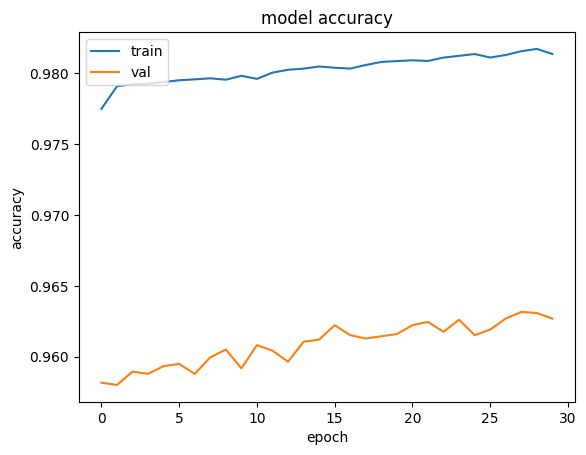

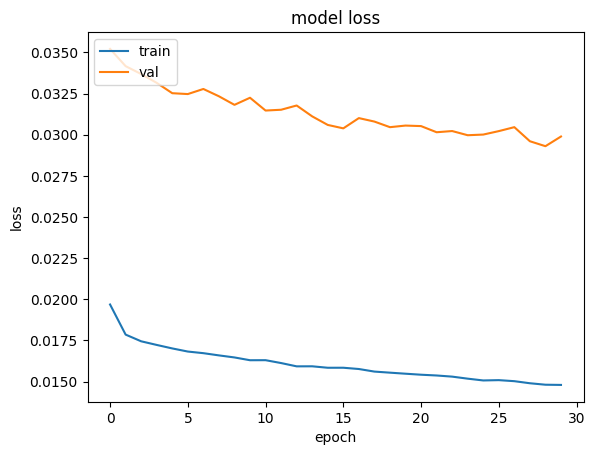

In [402]:
import time
exp_model = exp_model()

start = time.time()
#fit model
history = exp_model.fit(X_train3, Y_train3, epochs = 30, batch_size = 512, validation_data=(X_val3, Y_val3), verbose=1)
end = time.time()


print('program end...\n')
print('time cost: ')
print(end - start, 'seconds')

#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [403]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support,confusion_matrix, classification_report, precision_score, recall_score
from sklearn.metrics import f1_score as f1_score_rep

def print_score(y_pred, y_real):
    print("Accuracy: ", accuracy_score(y_real, y_pred))
    print("Precision:: ", precision_score(y_real, y_pred, average="micro"))
    print("Recall:: ", recall_score(y_real, y_pred, average="micro"))
    print("F1_Score:: ", f1_score_rep(y_real, y_pred, average="micro"))

    print()
    print("Classification Report")
    print(classification_report(y_real, y_pred))

In [404]:
y_pred = exp_model.predict(X_test3)
y_pred = np.argmax(y_pred, axis=1)
y_test_label =  Y_test3

print_score(y_pred, y_test_label)

401/401 [==============================] - 1s 3ms/step
Accuracy:  0.9581674861468821
Precision::  0.9581674861468821
Recall::  0.9581674861468821
F1_Score::  0.9581674861468821

Classification Report
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     12277
           1       0.00      0.00      0.00       536

    accuracy                           0.96     12813
   macro avg       0.48      0.50      0.49     12813
weighted avg       0.92      0.96      0.94     12813



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
